## Different used imports

In [1]:
from copy import deepcopy

from datetime import datetime

import numpy as np
import scipy

import pandas

import matplotlib.pyplot as plt

import scipy.fftpack
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
from scipy.interpolate import splrep, splev
from scipy.signal import savgol_filter

from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.nonparametric.kernel_regression import KernelReg

import pwlf

## Define a function to draw the different graphics below

In [2]:
def graphics(x, y, fmt, label, title):
    fig = plt.figure(figsize=(12,3), dpi=200)
    
    plt.title(title, size='x-large', weight='bold')
    for i in range (len(x)):
        plt.plot(x[i], y[i], fmt[i], markersize=3, label=label[i], alpha=0.7)
    plt.ylim(0,1)
    plt.ylabel('EVI', size='large', style='italic')
    plt.xlim(0,365)
    plt.xlabel("Year's day", size='large', style='italic')
    plt.legend(loc='center left', bbox_to_anchor=(1.01,0.5))
    plt.grid()
    
    fig.subplots_adjust(right=0.77)
    
    plt.show()

## Prepare data

### 1. Open MODIS data file

That's the same function as in First_treatments.ipynb

In [3]:
def prepareModisData(modisPath):
    """
        Read a .txt file to recover MODIS data pre-processed with phenograss_process_MODIS_v2.R
        by Jon Yearsley. The output is an array sorted by chronological order.
        
        :param modisPath: path to the file
        :type modisPath: str
        
        :return: array containing MODIS data
        :rtype: numpy.ndarray
    """
    modisFile = open(modisPath, 'r')
    modisData = []
    
    for line in modisFile.readlines():
        
        line = line.replace('"',  '')
        line = line.replace('\n', '')
        line = line.split(' ')
        
        if len(modisData) == 0:
            line.insert(0, 'id')
        else:
            line[0] = int(line[0])
            line[1] = float(line[1])
            line[2] = float(line[2])
            line[3] = float(line[3])
            line[4] = float(line[4])
            line[6] = int(line[6])
            line[7] = int(line[7])
            line[8] = int(line[8])
            line[9] = float(line[9])
            line[10] = float(line[10])
            line[11] = int(line[11])
            line[12] = datetime.strptime(line[12], '%Y-%m-%d')
            
        modisData.append(line)
        
    modisFile.close()
    
    header = modisData[0]
    modisData = sorted (modisData[1::], key=lambda day: day[8])
    modisData = np.insert(modisData, 0, header, axis=0)
    
    return modisData

#modisData, transpose, xMODIS, yMODIS, coordMODIS = [], [], [], [], []  

In [4]:
names = ['2017 Square1', '2017 Square2', '2017 Square3']
filePaths = ['modis_pasture_A2017_square1_d_sq.txt', 'modis_pasture_A2017_square2_d_sq.txt', 'modis_pasture_A2017_square3_d_sq.txt']

sevModisData = []

for f in filePaths:
    sevModisData.append(prepareModisData(f))

print (sevModisData[0])

[['id' 'x_ITM' 'y_ITM' ... 'ndvi' 'QC' 'date']
 [11 714443.370165114 761937.917724095 ... 0.669 1
  datetime.datetime(2017, 1, 1, 0, 0)]
 [12 714675.717152128 761943.567815079 ... 0.6735 1
  datetime.datetime(2017, 1, 1, 0, 0)]
 ...
 [181035 713912.47234178 752183.961850394 ... 0.6213 1
  datetime.datetime(2017, 12, 27, 0, 0)]
 [182741 717862.346898622 752280.817223724 ... 0.7633 1
  datetime.datetime(2017, 12, 27, 0, 0)]
 [182842 718094.69131406 752286.617449876 ... 0.7664 1
  datetime.datetime(2017, 12, 27, 0, 0)]]


### 2. Recuperate for each coordinates the appearance indexes

That's the same function as in First_treatments.ipynb

In [5]:
def loc(coordMODIS):
    """
        Return a dict with appearance indices of each coordinates.
        
        :param coordMODIS: an array with all coordinates
        :type coordMODIS: numpy.ndarray((float, float), ...)
        
        :return: {(xMODIS,yMODIS): [an appearance indice, another one, ...], ...}
        :rtype: dict
    """
    location = {}
    
    for i in range (len(coordMODIS)):
        key = (coordMODIS[i,0], coordMODIS[i,1])
        
        if key in location:
            indexes = location[key]
            indexes.append(i)
            location[key] = indexes
        else:
            location[key] = [i]
    
    return location

In [6]:
sevLocation = []

for d in sevModisData:
    transpose = d[1::].T
    xMODIS, yMODIS = transpose[3], transpose[4]
    coordMODIS = np.array([xMODIS,yMODIS]).T
    
    sevLocation.append(sorted(loc(coordMODIS).items(), key=lambda num: len(num[1]), reverse=True))

### 3. Just keep one (interesting) coordinate on each square to work here

In [7]:
pixLocation = [sevLocation[0][10], sevLocation[1][17], sevLocation[2][26]]

for n in range (len(names)):
    print ("Coordinates {}\nMeasured at indexes {}\n".format(pixLocation[n][0], pixLocation[n][1]))

Coordinates (-413390.771322034, 5959475.64451746)
Measured at indexes [2, 509, 979, 1327, 1792, 2218, 2635, 3462, 3691, 4107, 4539, 5000, 5666, 6292, 6460, 7269, 7738, 7854, 8316, 8762, 9566, 10019, 10273, 10631, 11120, 11209, 11498, 11983, 12244, 13004, 13470, 13549, 13668, 14326, 14699, 15194, 15707, 15717, 16589, 16672, 16822, 17094]

Coordinates (-457405.479392186, 5824419.98764957)
Measured at indexes [413, 1310, 1724, 2952, 4966, 5609, 7157, 7994, 8866, 9714, 11167, 12427, 14461, 14864, 15882, 17071, 17989, 19022, 21205, 21915, 23249, 24433, 25697, 27025, 27644, 28737, 30063, 31842, 32378, 32548, 33410, 33631, 35970, 37096, 38302, 40066, 41385, 42658, 44203, 44944, 46621, 47998, 49313]

Coordinates (-412232.489530714, 5879090.88819987)
Measured at indexes [273, 1692, 2837, 4040, 4588, 4859, 5199, 6018, 6557, 9347, 9690, 9742, 10629, 12200, 12457, 15315, 15604, 16999, 17664, 18650, 19757, 20318, 21813, 22180, 22269, 24939, 26992, 27127, 29912, 30440, 30897, 31707, 32193, 33284, 34

### 4. Plot EVI values with the information of quality given by MODIS

In [8]:
def pixelTimeSerie(location, modisData, title):

    key, value = location[0], location[1]
    
    transpose = modisData.transpose()
    
    year = transpose[7][1]
    
    quality  = []
    doy0, evi0 = [], []
    doy1, evi1 = [], []
    doy, evi = [], []

    for index in value:
        quality.append(transpose[11][index])

        if quality[-1] == 0:
            doy0.append(transpose[8][index])
            evi0.append(transpose[9][index])

        elif quality[-1] == 1:
            doy1.append(transpose[8][index])
            evi1.append(transpose[9][index])

        doy.append(transpose[8][index])
        evi.append(transpose[9][index])
        
    graphics([doy , doy0  , doy1  ],
             [evi , evi0  , evi1  ],
             ['k:', 'bo'  , 'ro'  ],
             [''  , 'QC=0', 'QC=1'],
             title)

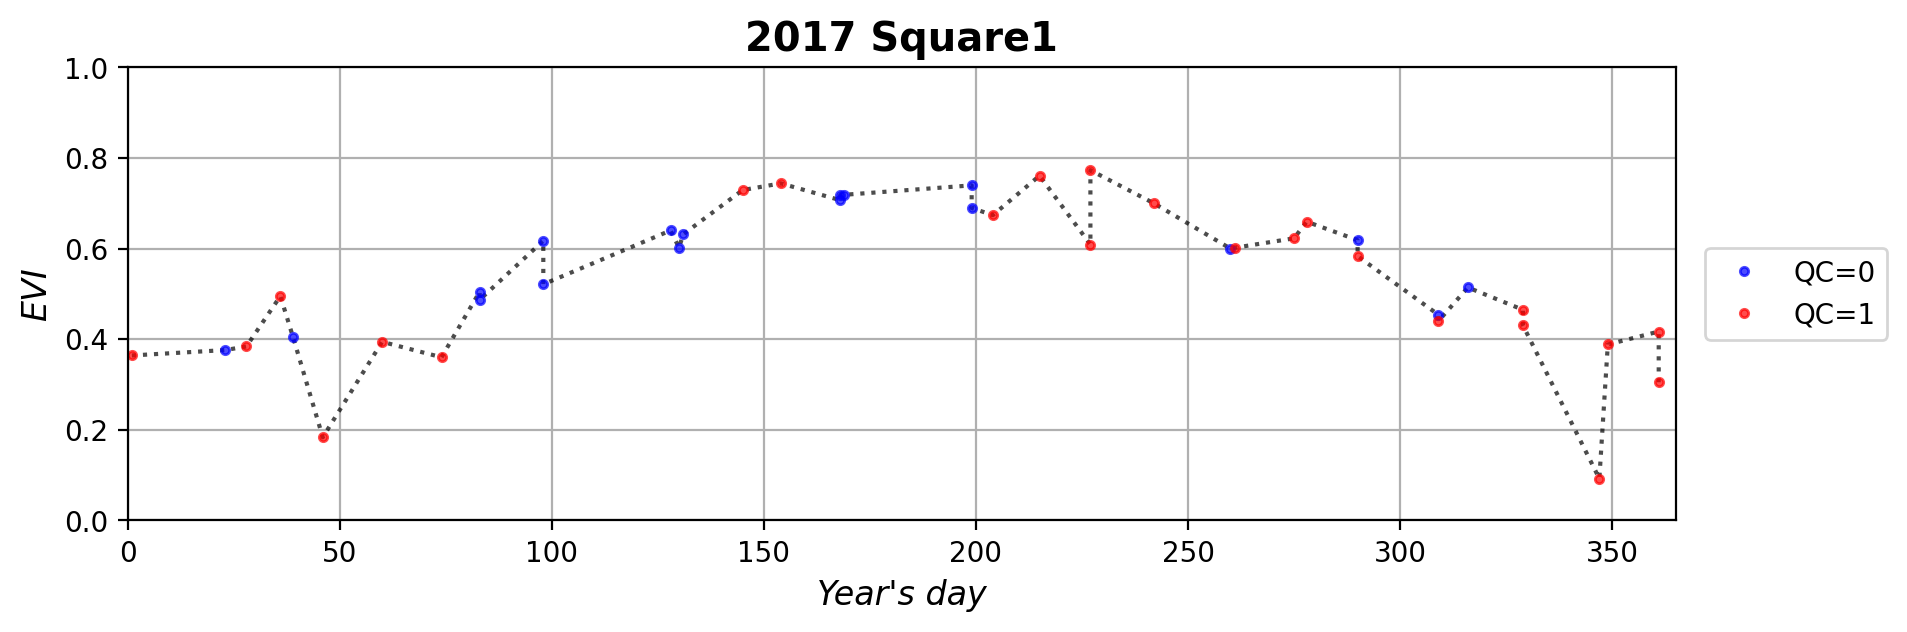

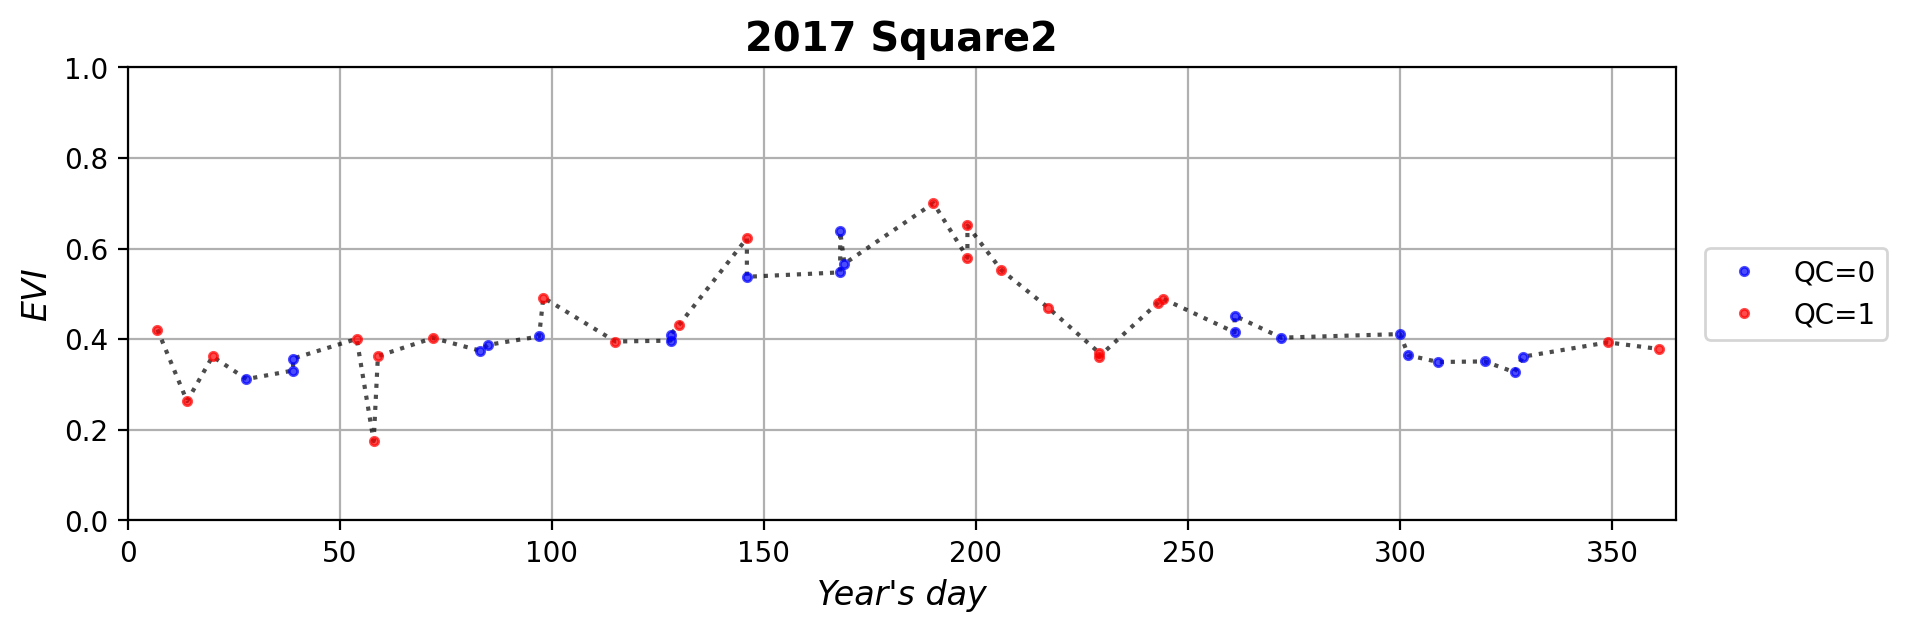

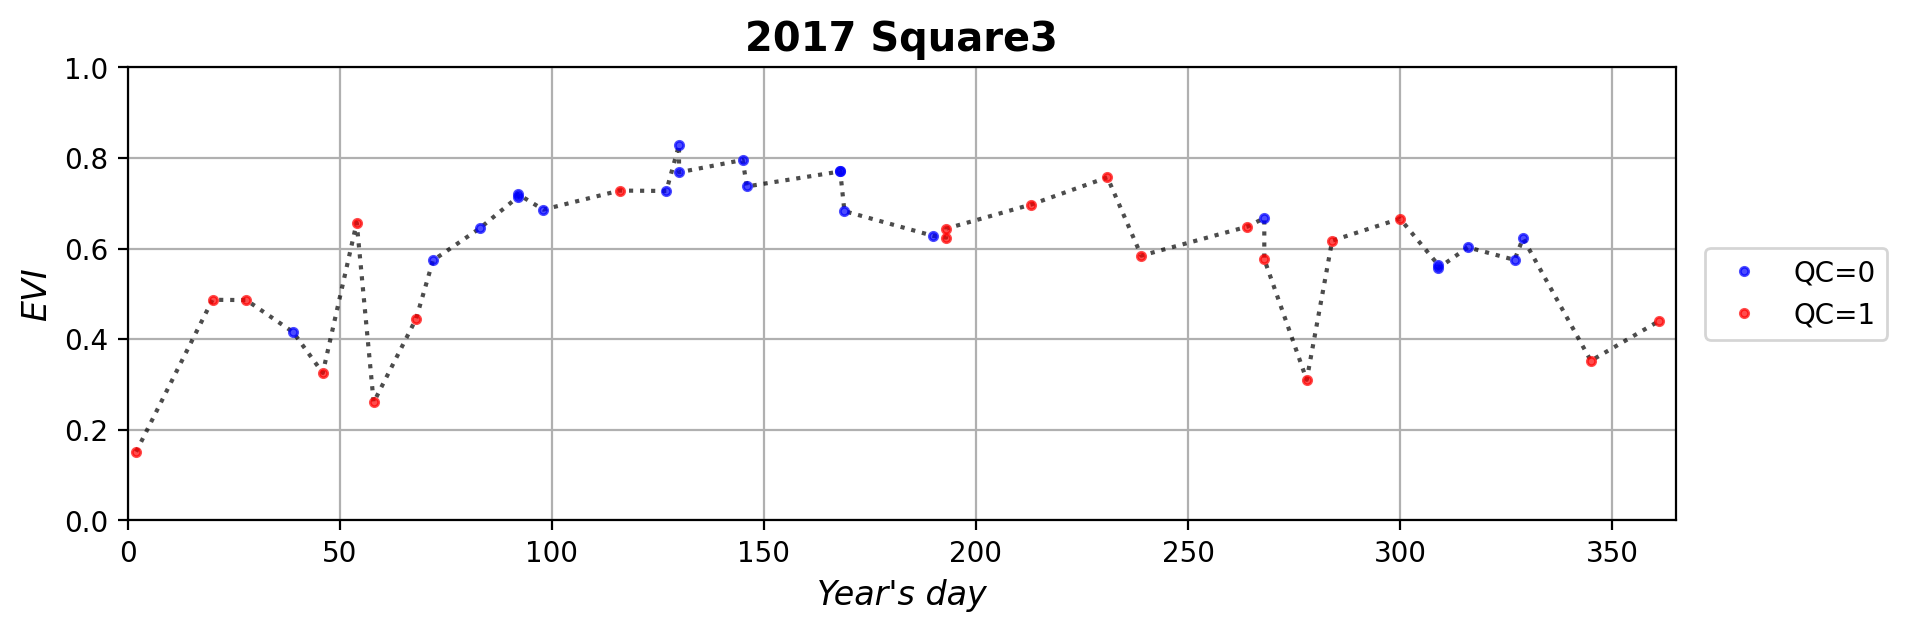

In [9]:
for n in range (len(names)):
    pixelTimeSerie(pixLocation[n], sevModisData[n], names[n])

### 5. Recuperate informations from the selected coordinates and perform a treatment when there are several measurements on an unique date:  <br/> &nbsp;&nbsp;&nbsp; - keep the value with the best quality flag <br/> &nbsp;&nbsp;&nbsp; - calculate the average on a day

In [10]:
def sameDate(location, modisData, title):
    
    key, value = location[0], location[1]
    
    transpose = modisData.transpose()
    
    year = transpose[7][1]
    
    quality, doy, evi, doyDate = [], [], [], []
    
    for index in value:
        quality.append(transpose[11][index])
        doy.append(transpose[8][index])
        evi.append(transpose[9][index])
        doyDate.append(datetime.strptime('{}-{}'.format(transpose[8][index], year), '%j-%Y'))
            
    if len(set(doy)) != len(doy):
        
        # Keep best quality values
        removeIndexes = []
        for i in range (len(doy)):
            for j in range (i+1, len(doy)):
                if doy[i] == doy[j]:
                    if quality[i] < quality[j]:
                        removeIndexes.append(j)
                    elif quality[j] < quality[i]:
                        removeIndexes.append(i)

        removeIndexes = sorted(set(removeIndexes), reverse=True)

        for index in removeIndexes:
            del quality[index]
            del doy[index]
            del evi[index]
            del doyDate[index]

        if len(set(doy)) != len(doy):
            # Take the average
            finished = False
            treatedDays = []
            while finished == False:
                finished = True
                for i in range (len(doy)):
                    if doy[i] in treatedDays:
                        continue
                    else:
                        treatedDays.append(doy[i])
                        indSame = []
                        for j in range (i+1, len(doy)):
                            if doy[i] == doy[j]:
                                indSame.append(j)

                        if len(indSame) > 0:

                            finished = False

                            eviAverage = evi[i]

                            for k in indSame:
                                eviAverage += evi[k]
                            eviAverage /= (len(indSame) + 1)

                            for k in reversed(indSame):
                                del quality[k]
                                del doy[k]
                                del evi[k]
                                del doyDate[k]

                            evi[i] = eviAverage

                            break
    
    doy0, evi0 = [], []
    doy1, evi1 = [], []

    for i in range(len(doy)):
        if quality[i] == 0:
            doy0.append(doy[i])
            evi0.append(evi[i])

        elif quality[i] == 1:
            doy1.append(doy[i])
            evi1.append(evi[i])

    graphics([doy , doy0  , doy1  ],
             [evi , evi0  , evi1  ],
             ['k:', 'bo'  , 'ro'  ],
             [''  , 'QC=0', 'QC=1'],
             title)
    
    return [quality, doy, evi, doyDate]

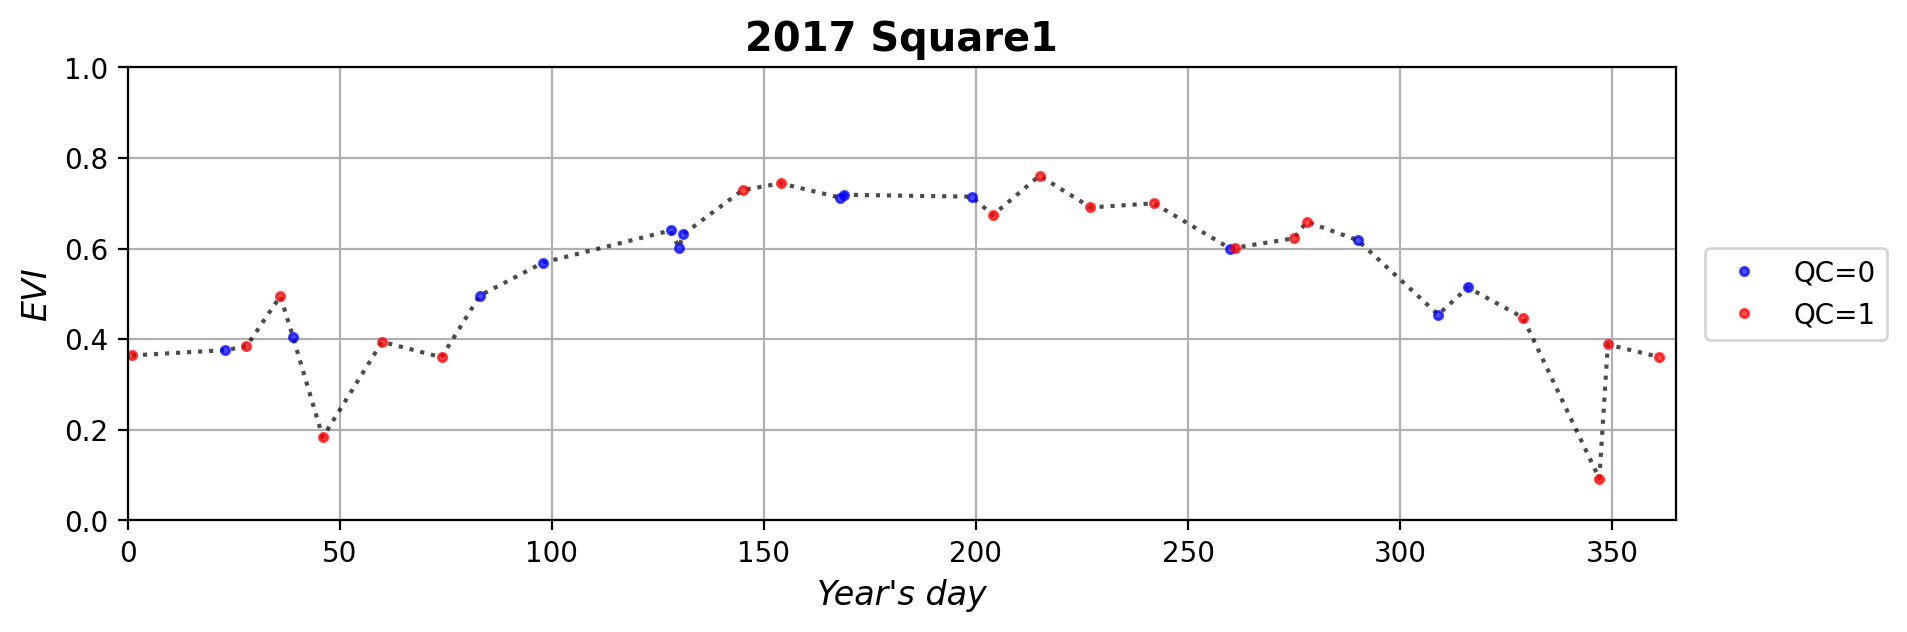

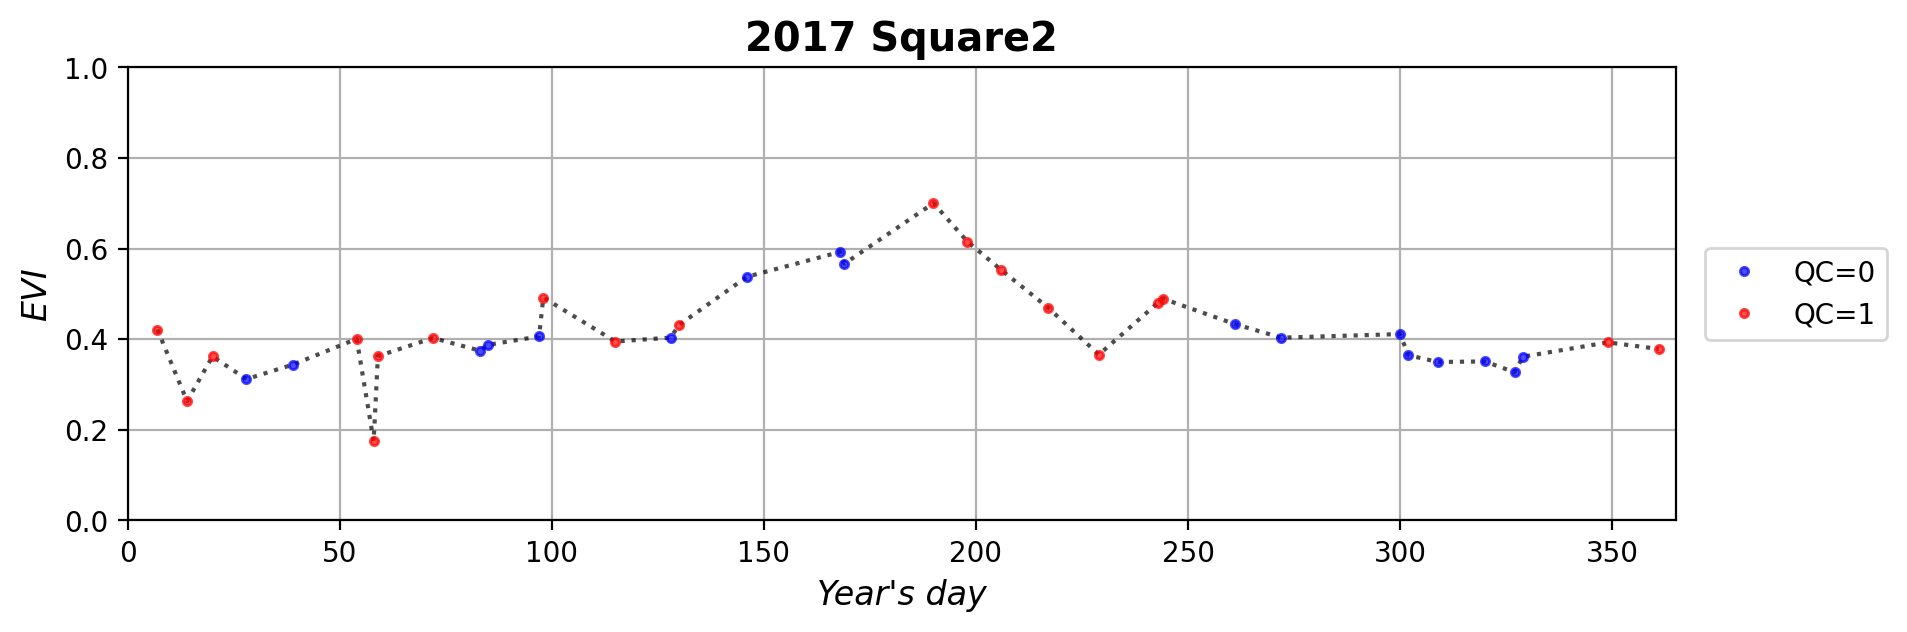

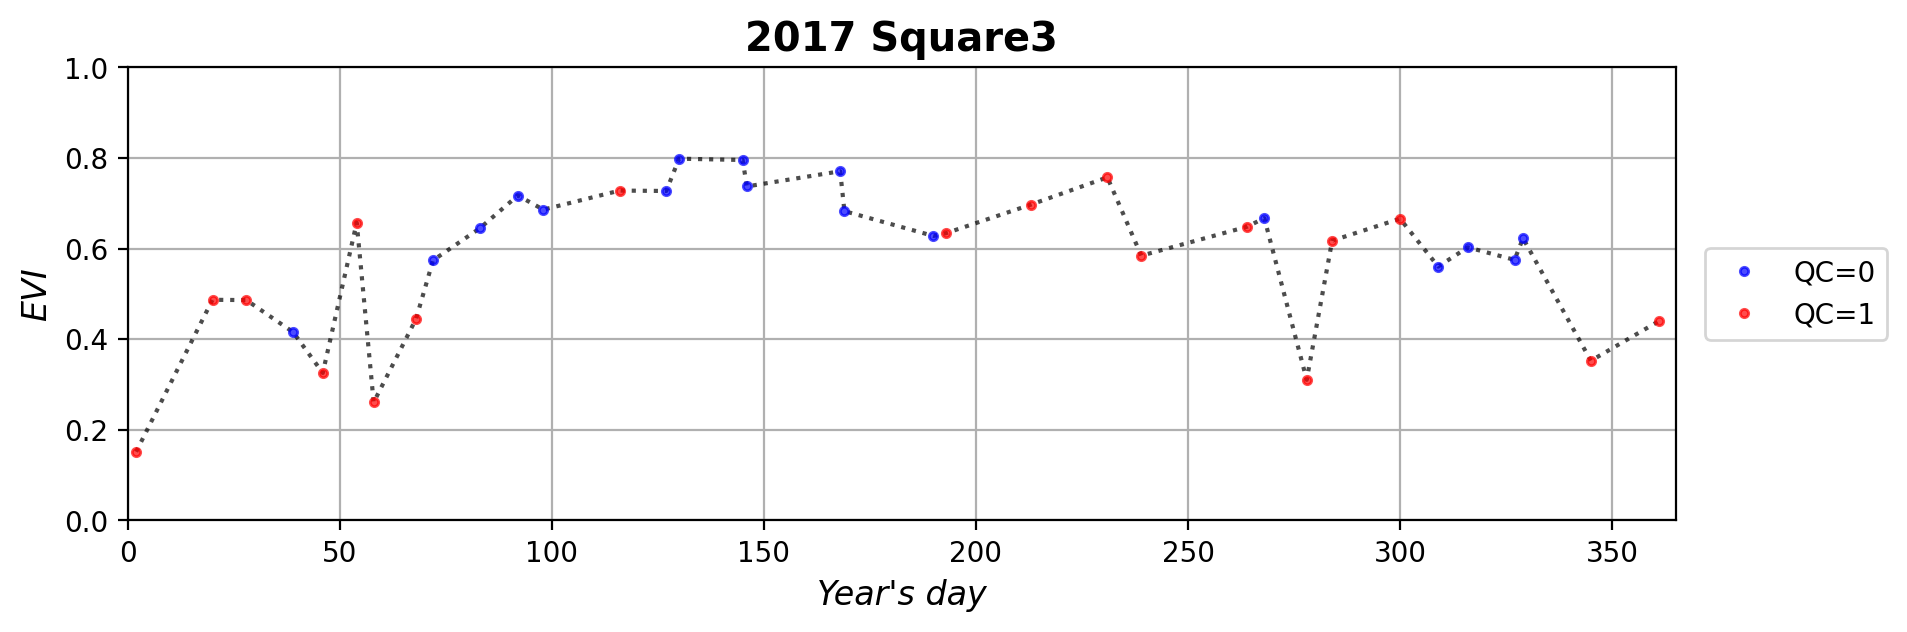

In [11]:
sevNewData = []
for n in range (len(names)):
    sevNewData.append(sameDate(pixLocation[n], sevModisData[n], names[n]))

### 6. Outliers filtering with polynomial fit of degree 3

Not used

In [12]:
#doyList = deepcopy(doySevList)
#eviList = deepcopy(eviSevList)
#
#eviPolNoFiltering = []
#
#doyPolyList = deepcopy(doyList)
#doyDatePolyList = deepcopy(doyDateList)
#eviRawPolyList = deepcopy(eviList)
#qualityPolyList = deepcopy(qualityList)
#
#weightsPolyList = []
#weightsList = []
#doyHatList = []
#eviPolyList = []
#
#messageList = []
#
#for f in range (len(files)):
#    
#    message = ''
#    
#    doyHat = np.linspace(min(doyPolyList[f]), max(doyPolyList[f]), 1000)
#    doyHat = sorted(list(doyHat) + doyPolyList[f])
#    
#    doyHatList.append(doyHat)
#
#    # Weight list
#    weights = []
#    for q in qualityPolyList[f]:
#        if q == 0:
#            weights.append(1)
#        elif q == 1:
#            weights.append(0.5)
#    
#    weightsList.append(weights)
#    weightsPolyList.append(weights)
#
#    # Iterations to remove outliers
#    finished, it = False, 0
#    while not finished:
#        message += "Iteration {}\n".format(it)
#        it += 1
#
#        finished = True
#
#        # Least squares polynomial fit of degree 3
#        eviPoly = np.poly1d(np.polyfit(doyPolyList[f], eviRawPolyList[f], 3, w=weightsPolyList[f]))(doyHat)
#        
#        if (len(eviPolNoFiltering)) == f:
#            eviPolNoFiltering.append(eviPoly)
#            
#        diff = []
#        for i in range (len(doyPolyList[f])):
#            diff.append(eviRawPolyList[f][i] - eviPoly[doyHat.index(doyPolyList[f][i])])
#
#        standardDev = np.std(diff)
#
#        diff = [abs(d) for d in diff]
#        res = 'passed'
#
#        if max(diff) > 0.2:
#            res = 'deleted'
#            finished = False
#            index = diff.index(max(diff))
#
#            del doyPolyList[f][index]
#            del doyDatePolyList[f][index]
#            del eviRawPolyList[f][index]
#            del qualityPolyList[f][index]
#            del weightsPolyList[f][index]
#
#        message += "Standard deviation = {} & Error max = {} --> {}\n\n".format(round(standardDev,5), round(max(diff),5), res)
#    
#    messageList.append(message)
#    
#    eviPolyList.append(eviPoly)
#
## Graphics
#def updatePlot(file, polFiltering):
#    if polFiltering:
#        print (messageList[file])
#        graphics([doyPolyList[file]   , doyHatList[file] ],
#                 [eviRawPolyList[file], eviPolyList[file]],
#                 ['b:o'               , 'r'              ],
#                 ['Raw data'          , 'Polynomial fit' ],
#                 'Polynomial fit')
#    else:
#        graphics([doyList[file], doyHatList[file]       ],
#                 [eviList[file], eviPolNoFiltering[file]],
#                 ['b:o'        , 'r'                    ],
#                 ['Raw data'   , 'Polynomial fit'       ],
#                 'Polynomial fit')
#
#polFilter = [('w/', True), ('w/o', False)]
#
#interact(updatePlot, file=names, polFiltering=polFilter)

### 7. Perform interpolation to have constant time interval

In [13]:
def interpolation(modisData, title):
    # Series values
    eviSeries = pandas.Series(modisData[2], pandas.to_datetime(modisData[3]))
    
    # also possible to use method='pchip'
    eviUpSeries = eviSeries.resample('1D', axis=0, kind='DateTimeIndex').interpolate(method='linear')
    
    # List values
    doyUp = np.arange(min(modisData[1]), max(modisData[1]) + 1, 1)
    eviUpArray = eviUpSeries.values
    
    graphics([doyUp        , modisData[1]   ],
             [eviUpArray   , modisData[2]   ],
             ['ro'                , 'b:o'        ],
             ['Interpolated data' , 'Raw data'   ],
             title)
    
    return ([doyUp, eviUpArray])

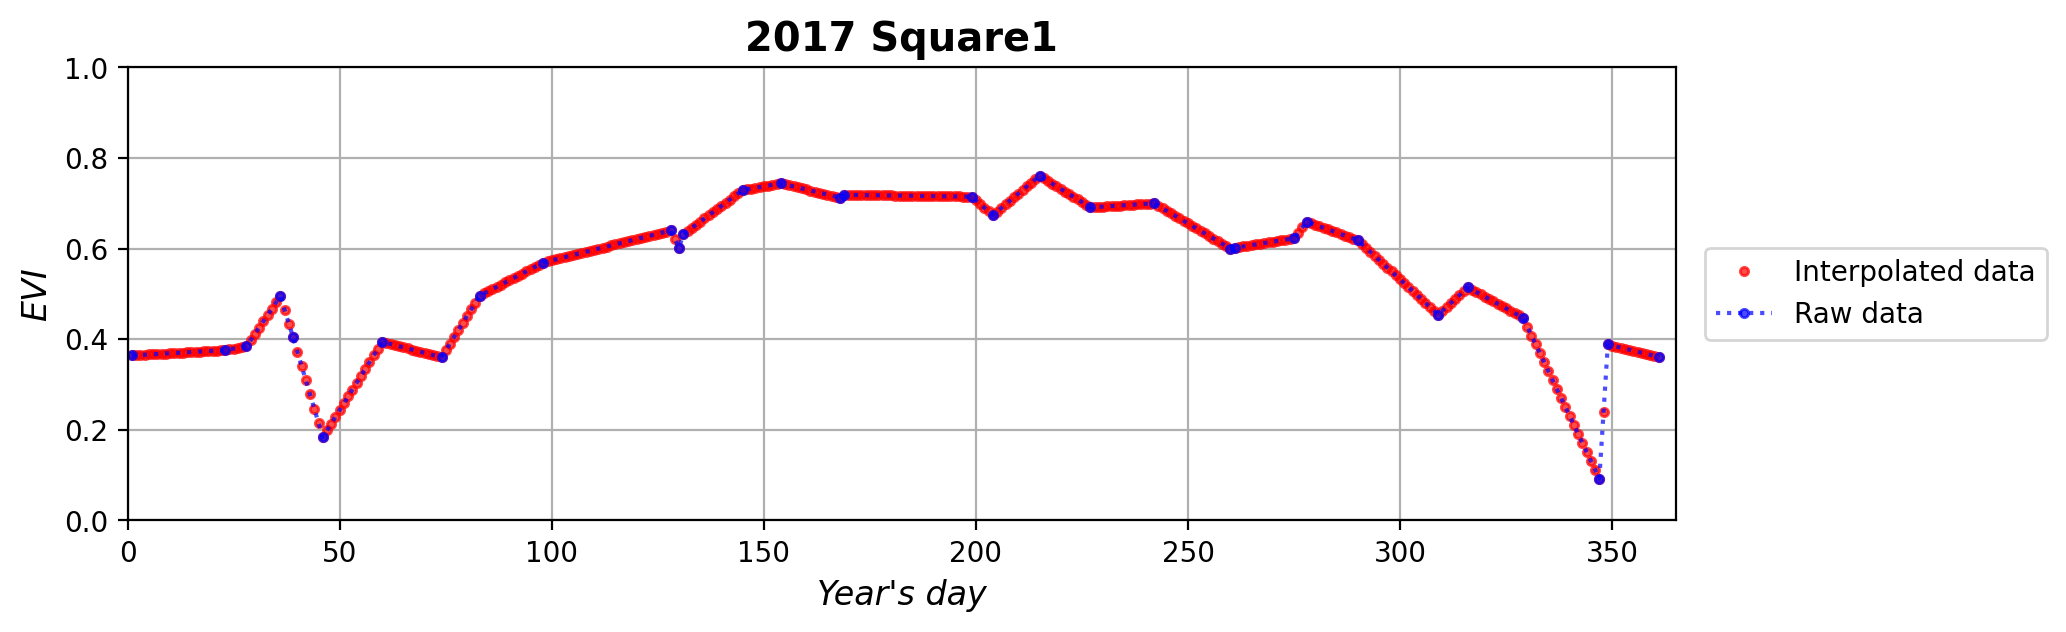

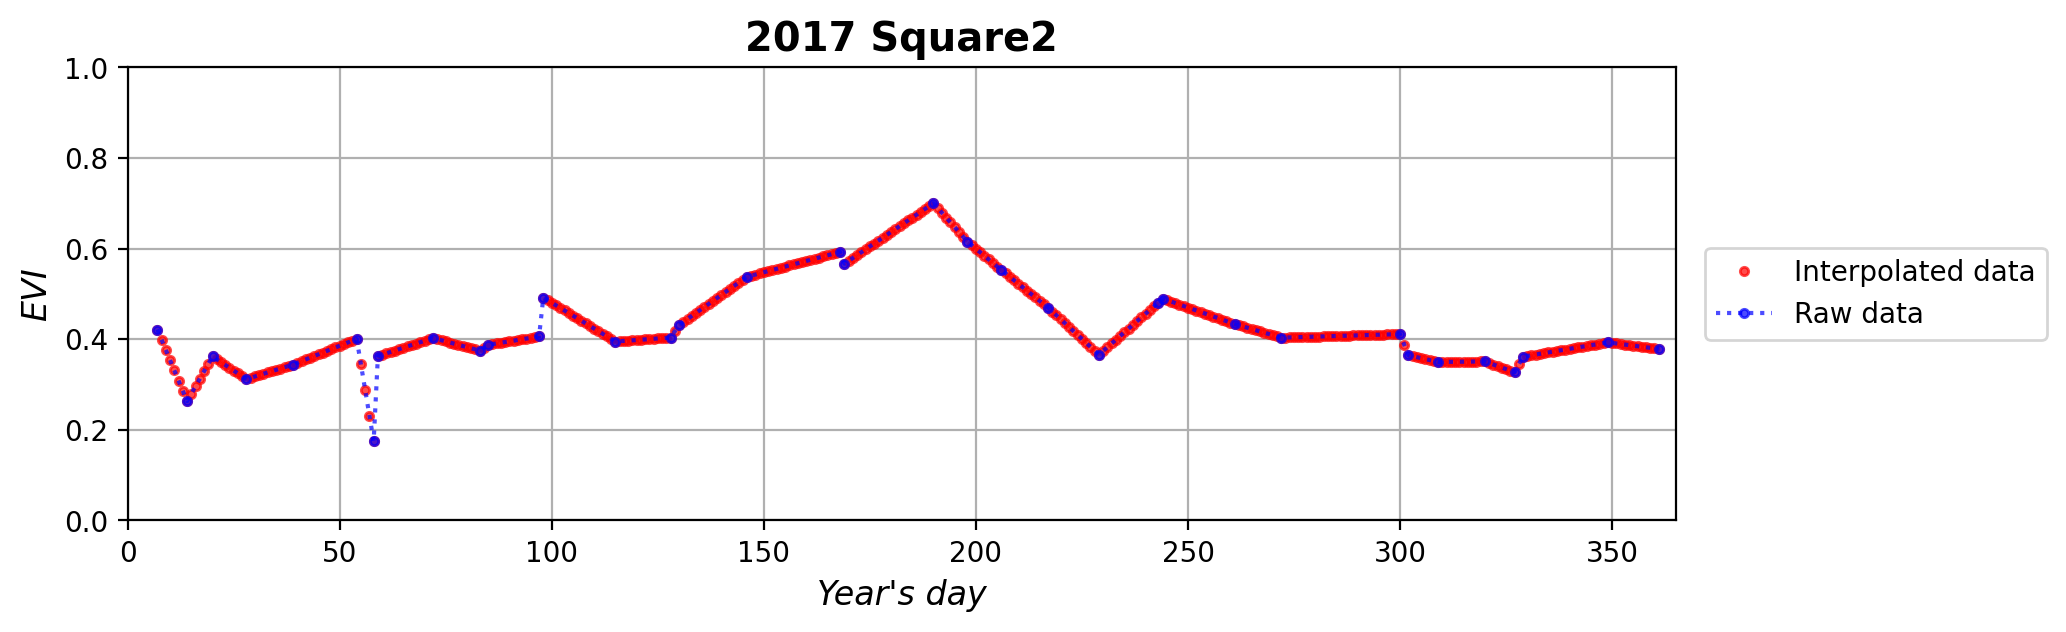

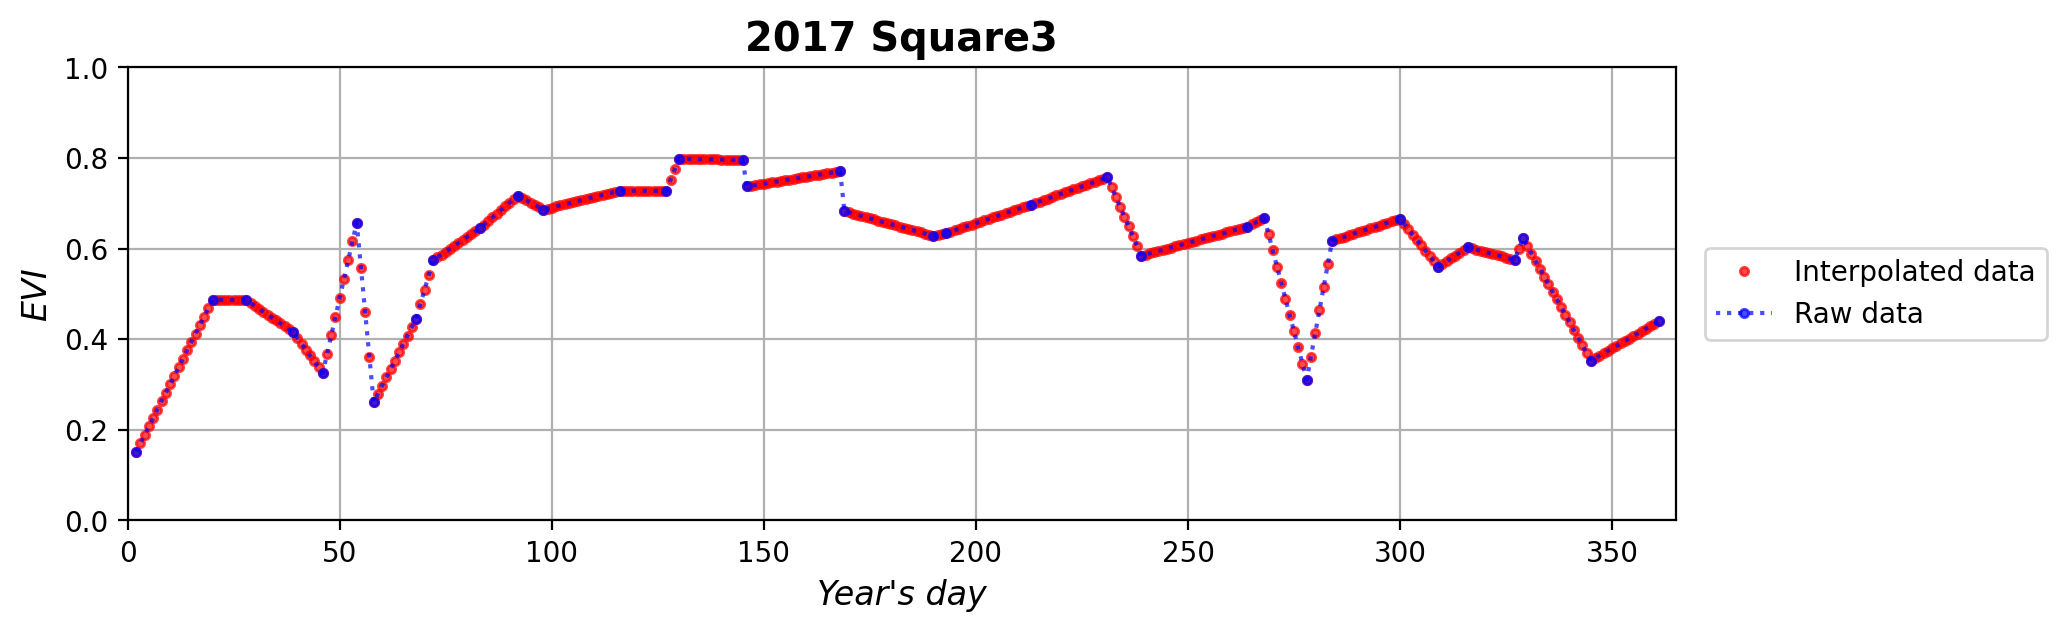

In [14]:
for n in range (len(names)):
    sevNewData[n]  = sevNewData[n] + interpolation(sevNewData[n], names[n])

## Smoothing

sevNewData list = [[quality, doy, evi, doyDate, doyUp, eviUpArray, eviUpSeries], ...]

### 1. Kernel regression

In [15]:
def kernelSmoothing(modisData, bandwithValue, title):
    eviKernel = KernelReg(modisData[5], modisData[4], var_type='c', bw=[bandwithValue]).fit()
    
    graphics([modisData[1], modisData[4]                        ],
             [modisData[2], eviKernel[0]                        ],
             ['b:o'       , 'r'                                 ],
             ['Raw data'  , 'bandwidth={}'.format(bandwithValue)],
             title)

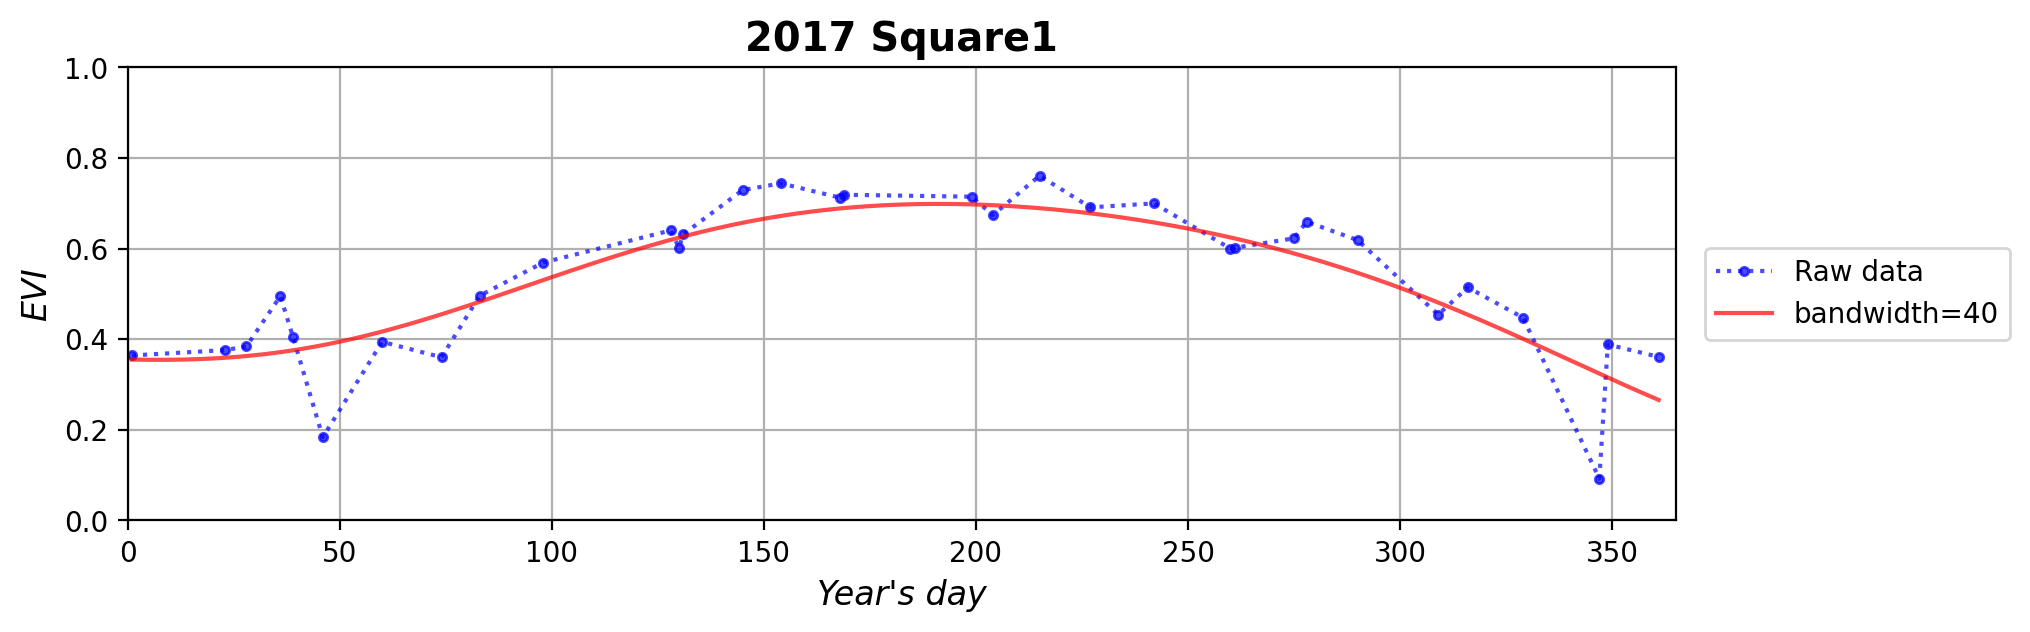

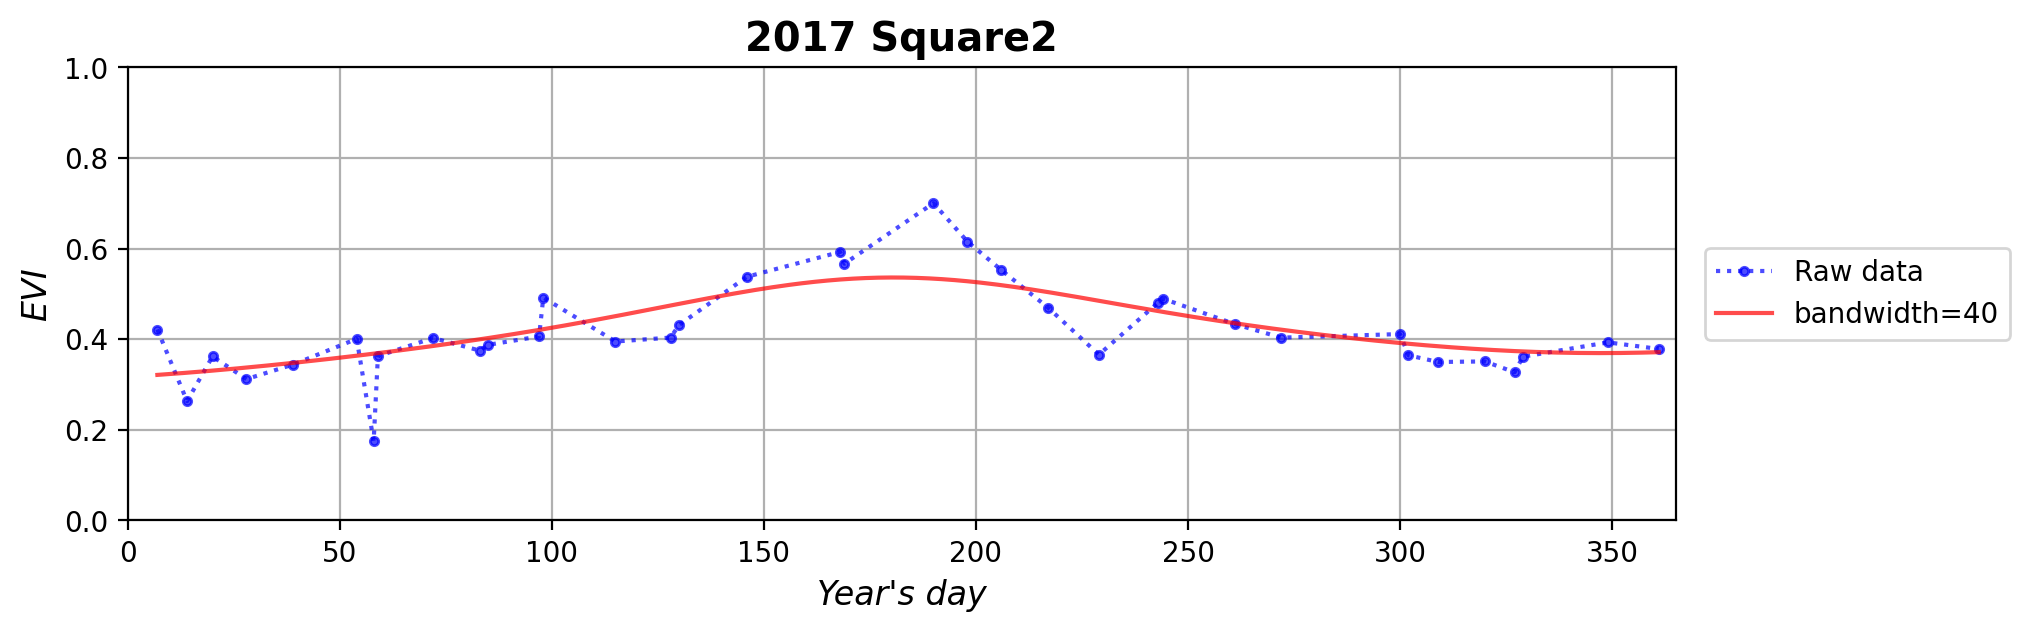

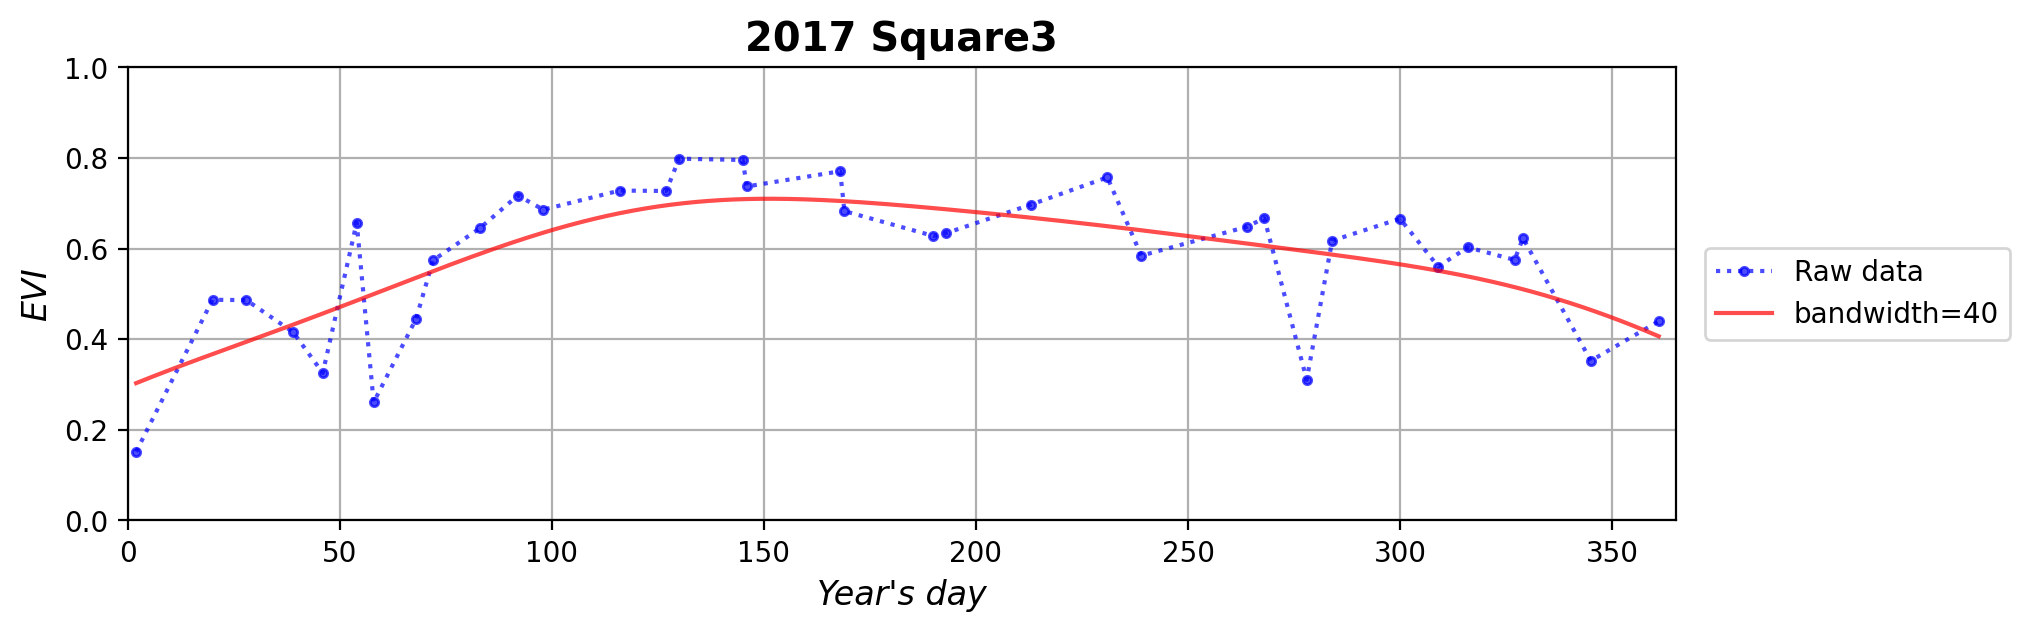

In [16]:
for n in range (len(names)):
    kernelSmoothing(sevNewData[n], 40, names[n])

### 2. Lowess smoothing

In [17]:
def lowessSmoothing(modisData, fracValue, title):
    eviLowess = lowess(modisData[5], modisData[4], frac=fracValue, it=50, is_sorted=True)       
    
    graphics([modisData[1], eviLowess[:,0]             ],
             [modisData[2], eviLowess[:,1]             ],
             ['b:o'       , 'r'                        ],
             ['Raw data'  , 'frac={}'.format(fracValue)],
             title)

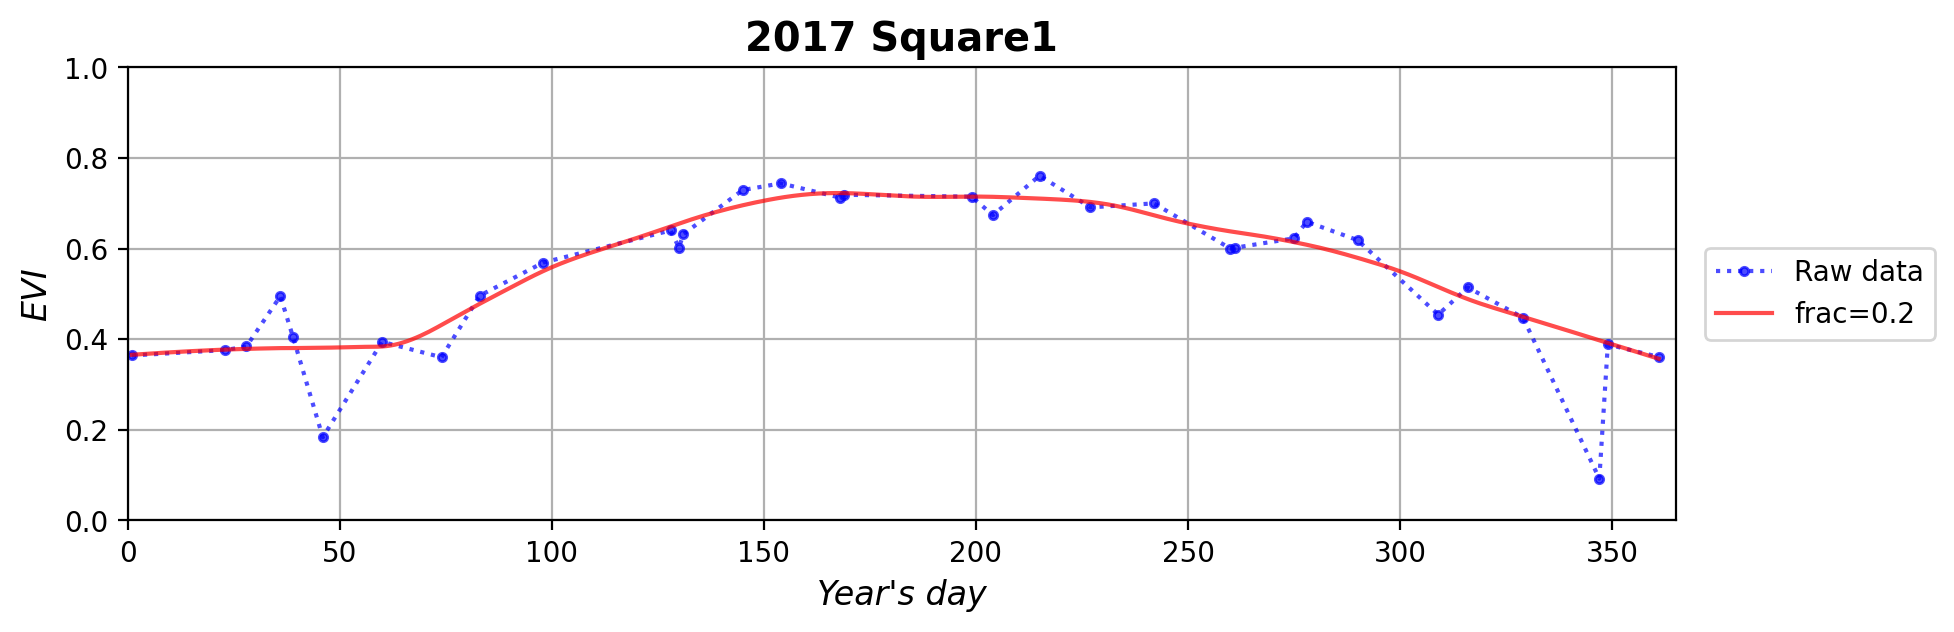

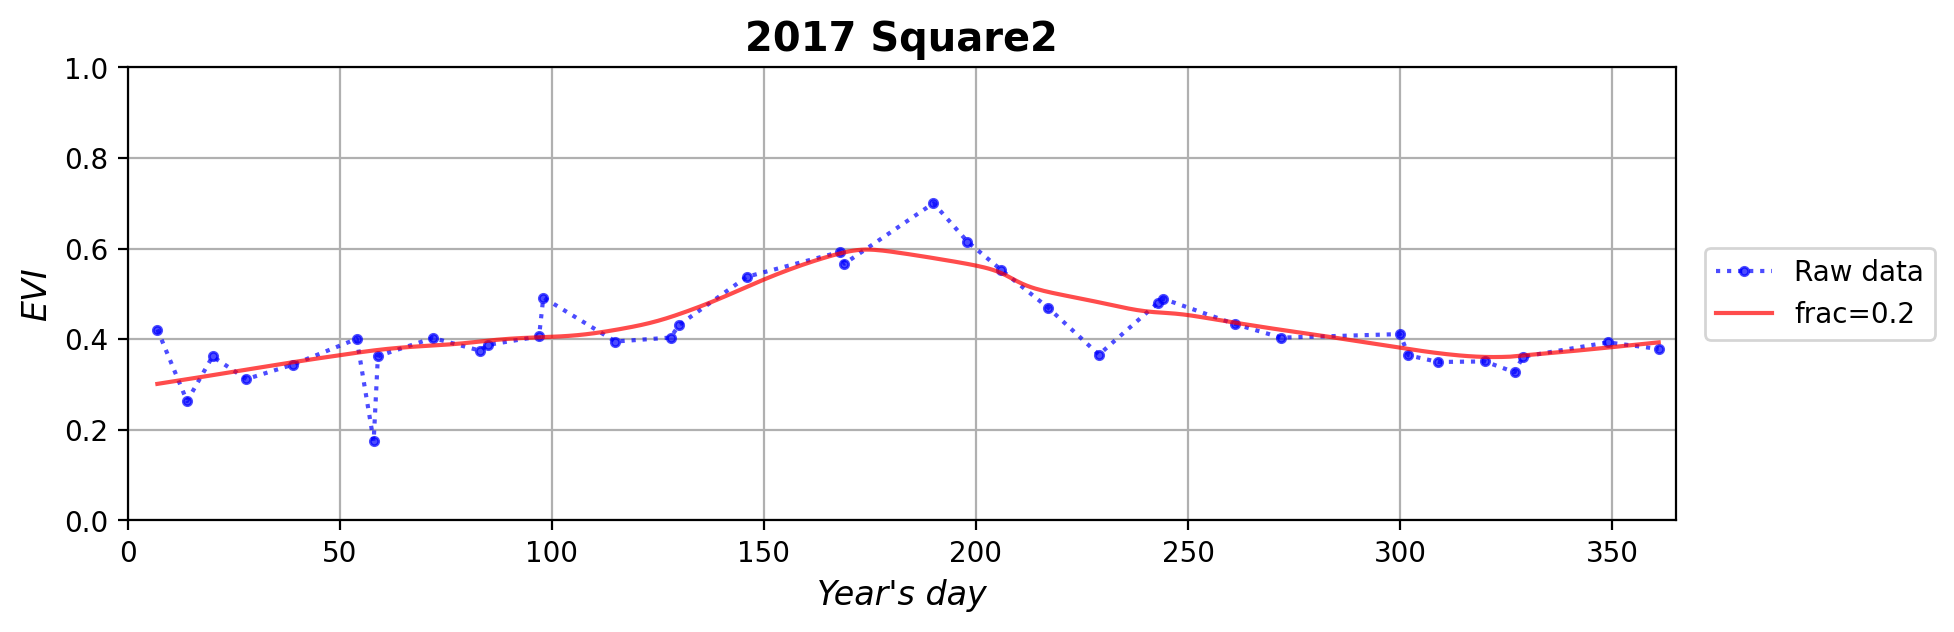

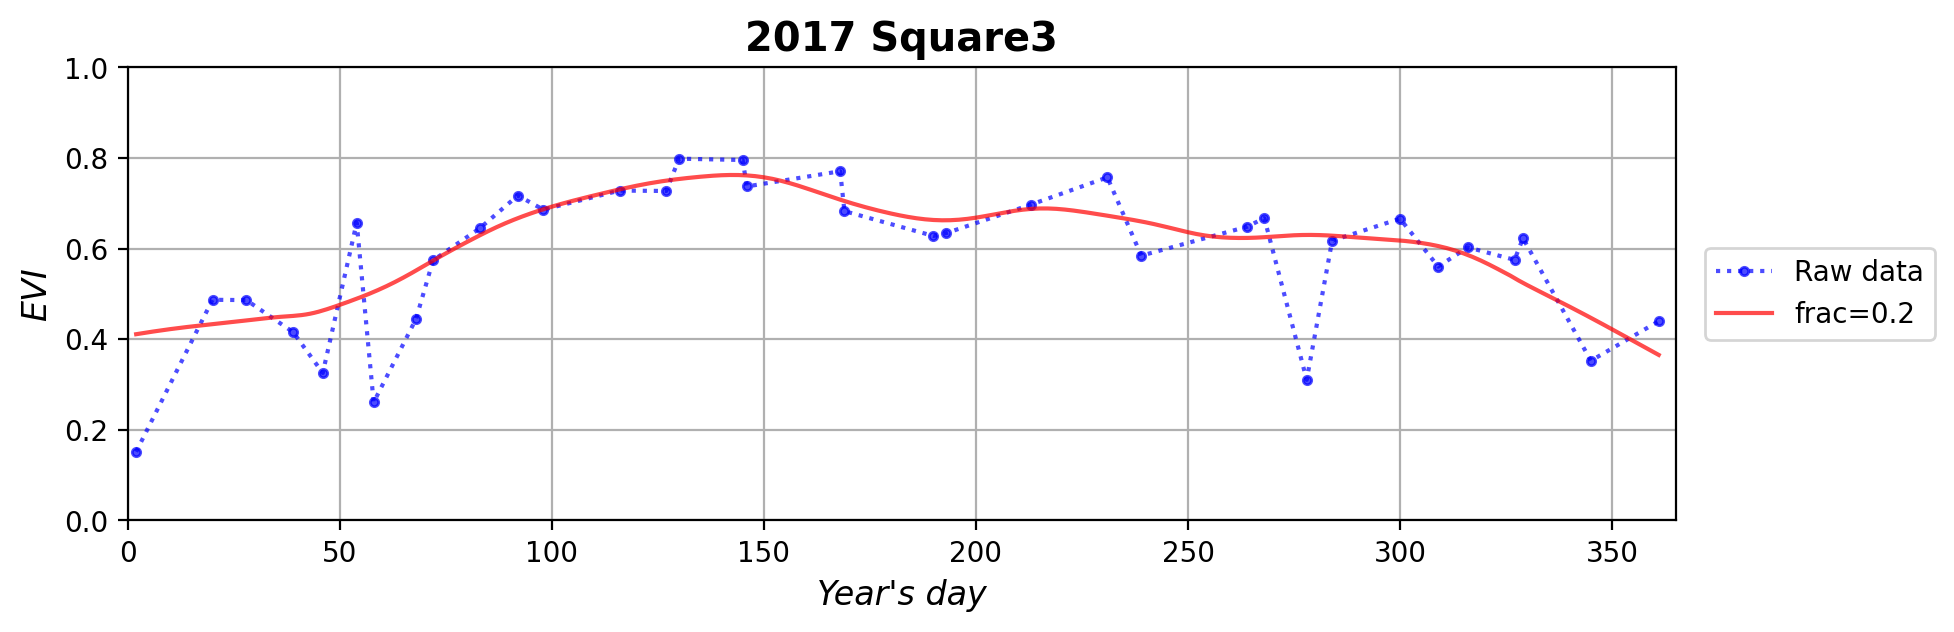

In [18]:
for n in range (len(names)):
    lowessSmoothing(sevNewData[n], 0.2, names[n])

### 3. Savitzky-Golay filter

In [19]:
def savGol1Smoothing(modisData, windowValue, orderValue, title):
    eviSavGol1 = savgol_filter(modisData[5], 81, orderValue)
    
    graphics([modisData[1], modisData[4]                   ],
             [modisData[2], eviSavGol1                     ],
             ['b:o'       , 'r'                            ],
             ['Raw data'  , 'window={}'.format(windowValue)],
             title)

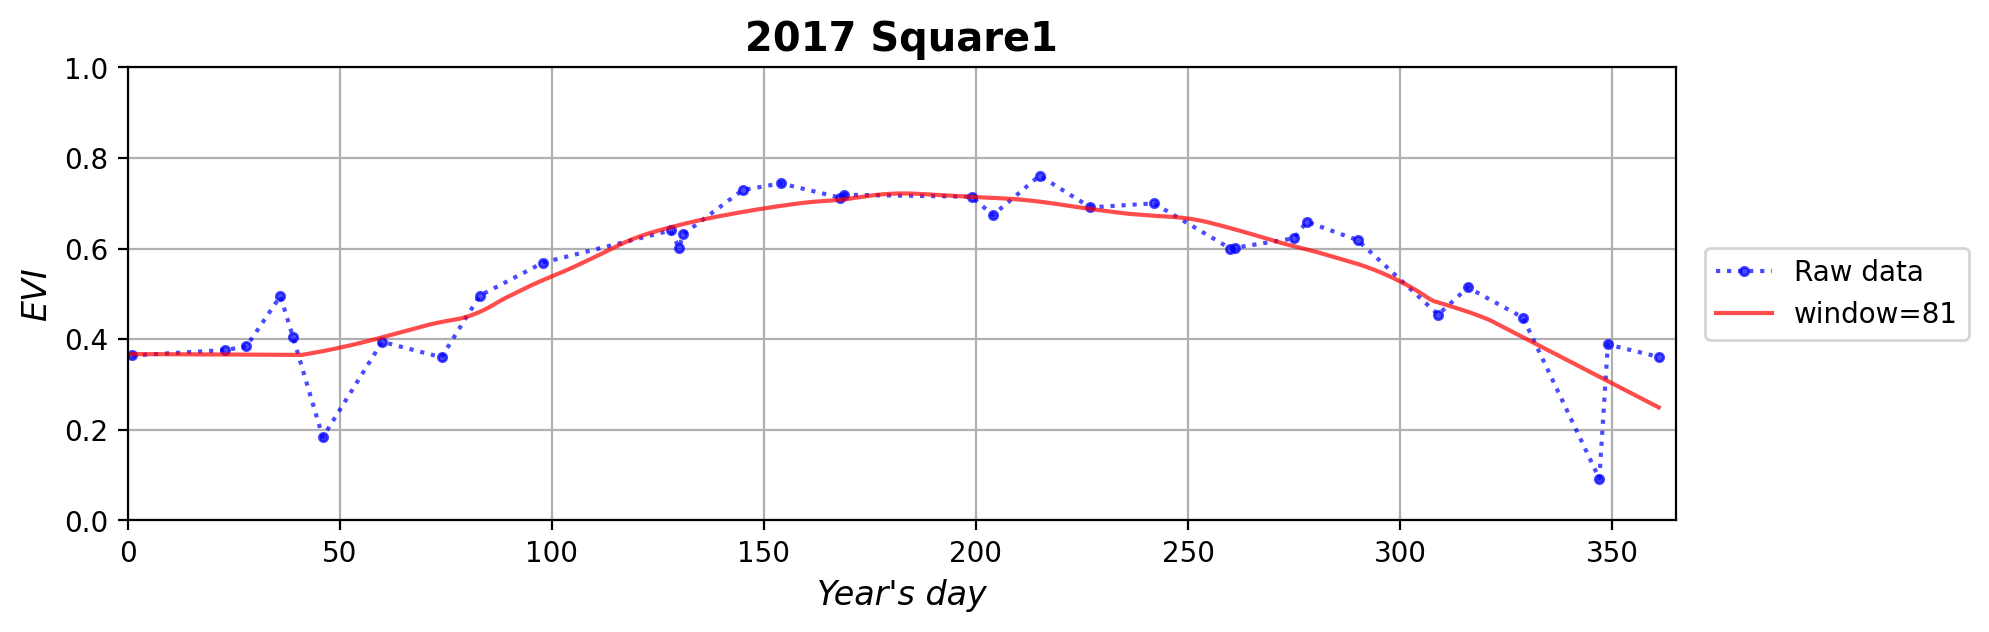

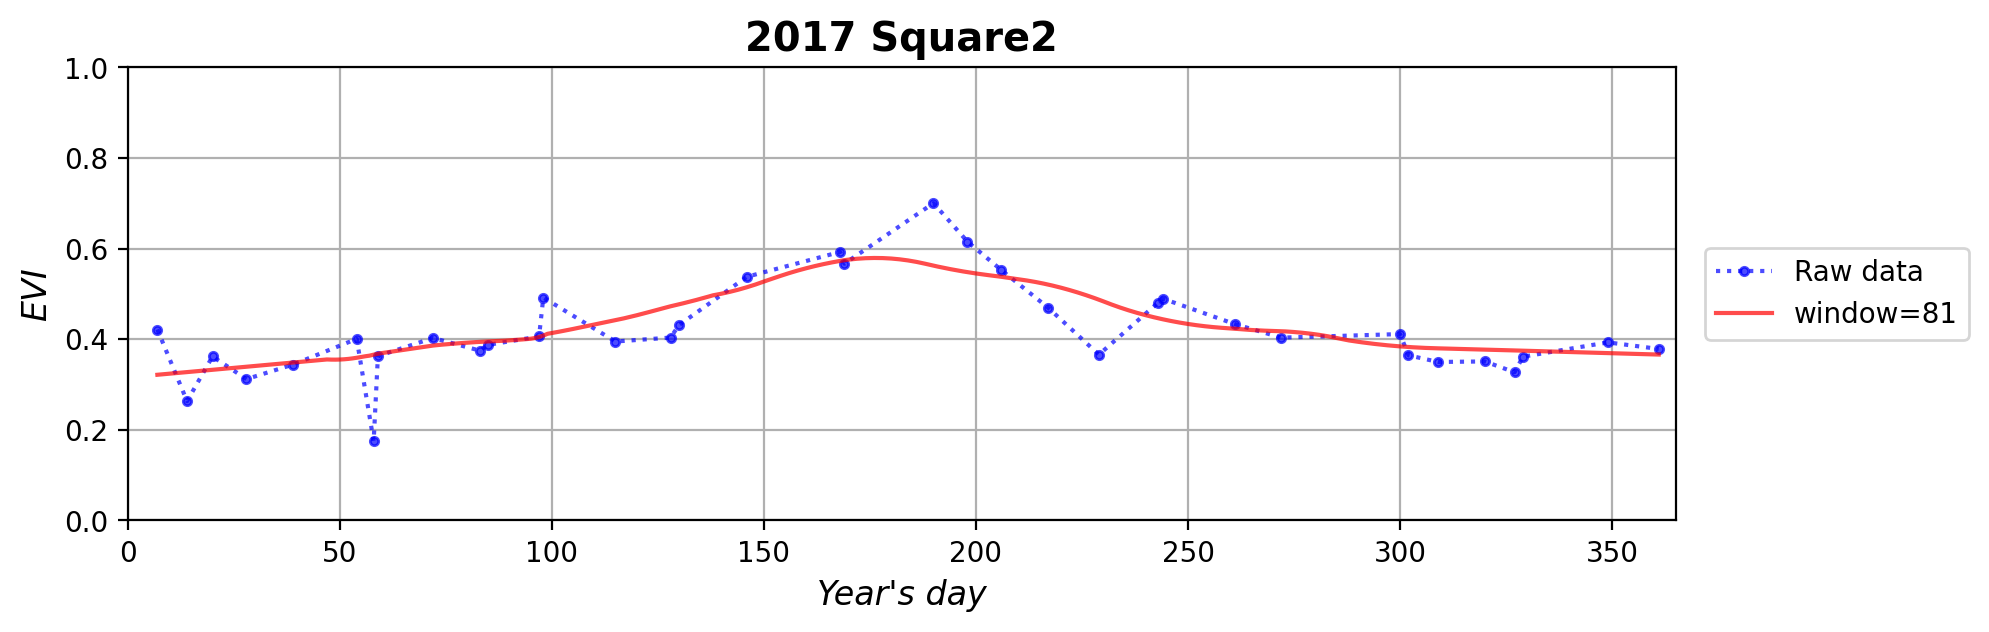

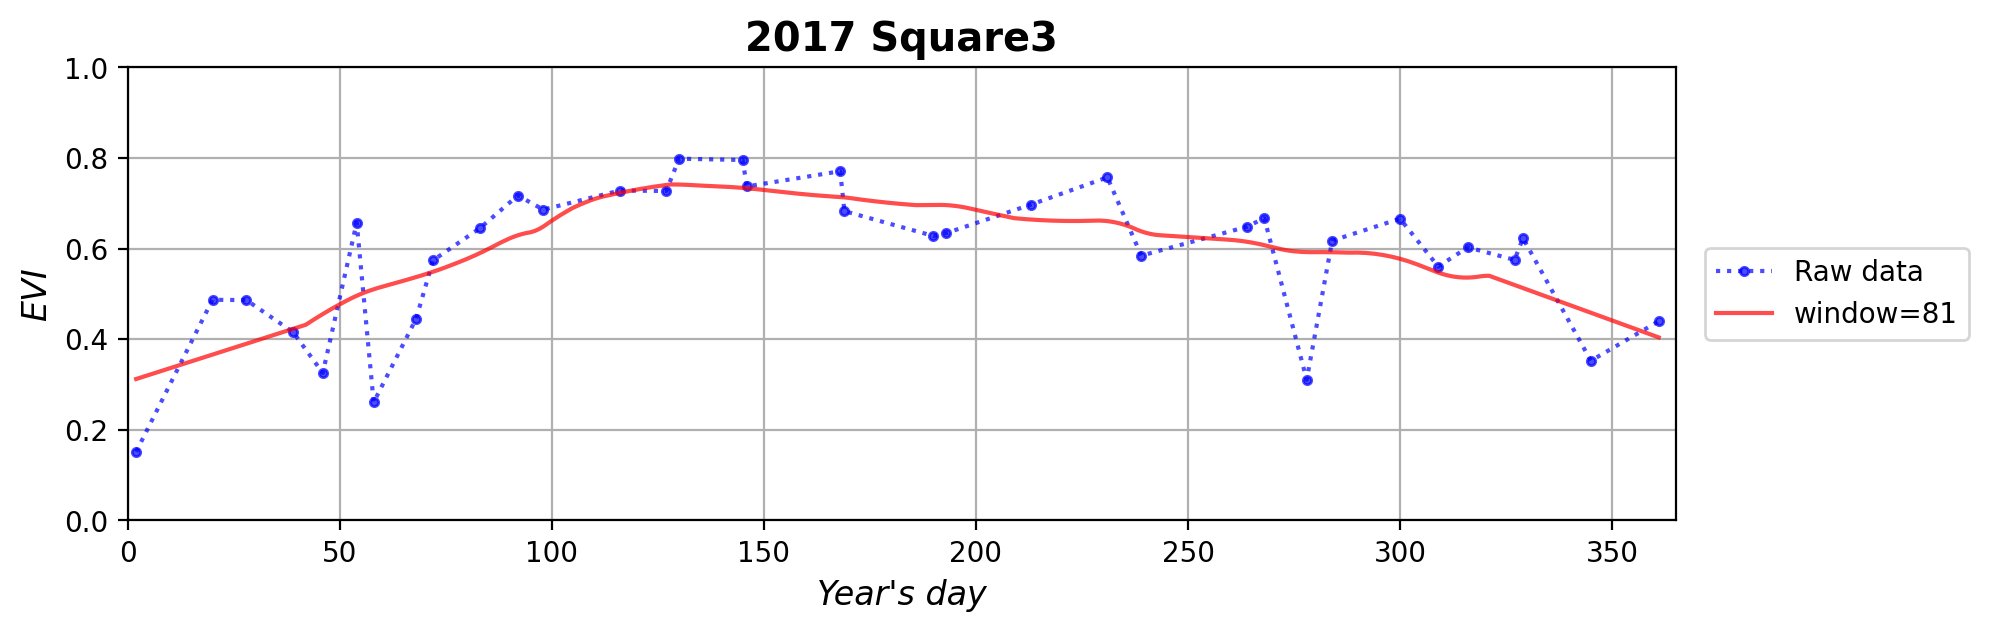

In [20]:
for n in range (len(names)):
    savGol1Smoothing(sevNewData[n], 81, 1, names[n])

### 4. Fourier smoothing

#### 1. Low pass filter with precise frequency

In [21]:
# Sample period: ~365 days
# Sampling freq: ideally, maximum, 365/8 = 45 --> 45/365=1.23*10^(-1)
# Signal freq: 1 signal per year --> 1/365=2.74*10^(-3)
# Sample rate = len(measurements) / T
# Nyquist frequency = 0.5 * sample rate

def fourierFreqSmoothing(modisData, cutoffFrequency, title):
    eviRft = scipy.fftpack.rfft(modisData[5])
    freq = scipy.fftpack.fftfreq(modisData[5].size, d=1)
    
    eviRft[(freq<0)] = 0
    
    eviRft[(freq>cutoffFrequency)] = 0
    
    eviFourier = scipy.fftpack.irfft(eviRft, n=modisData[5].size)
    
    graphics([modisData[1], modisData[4]                         ],
             [modisData[2], eviFourier                           ],
             ['b:o'       , 'r'                                  ],
             ['Raw data'  , 'Cutoff = {}'.format(cutoffFrequency)],
             title)

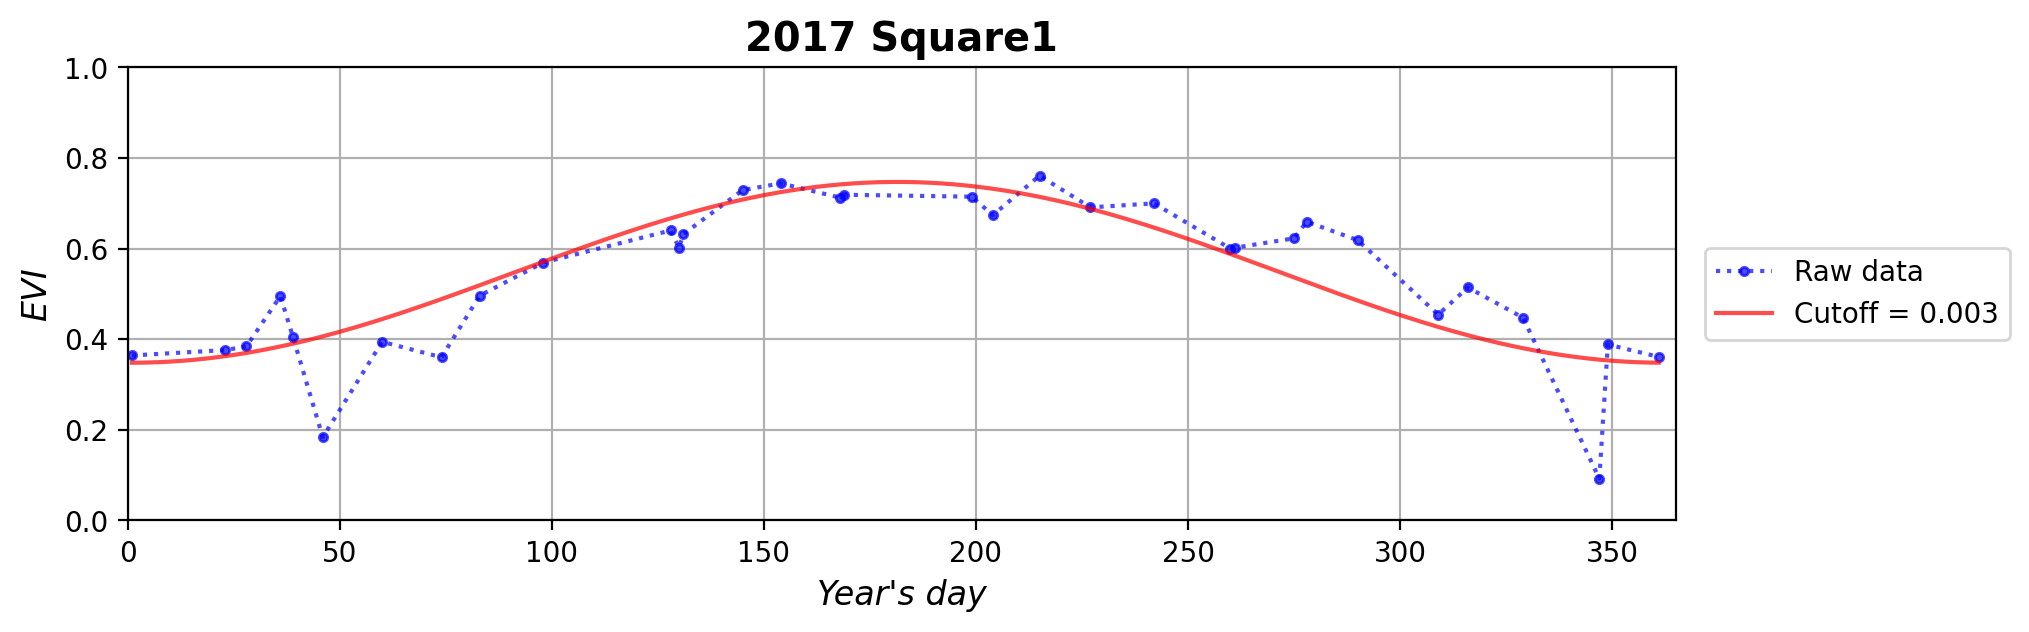

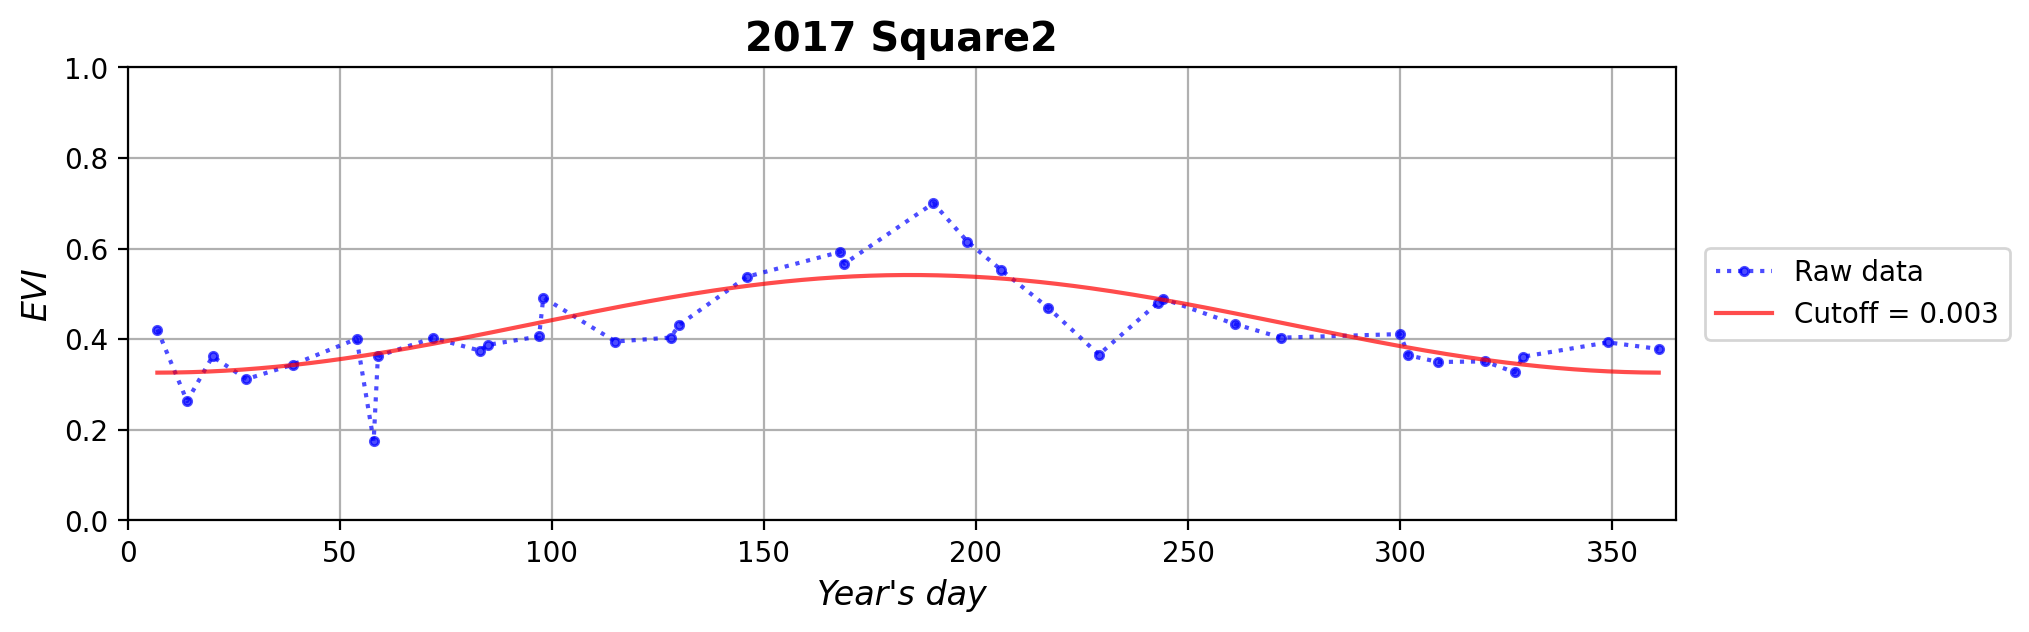

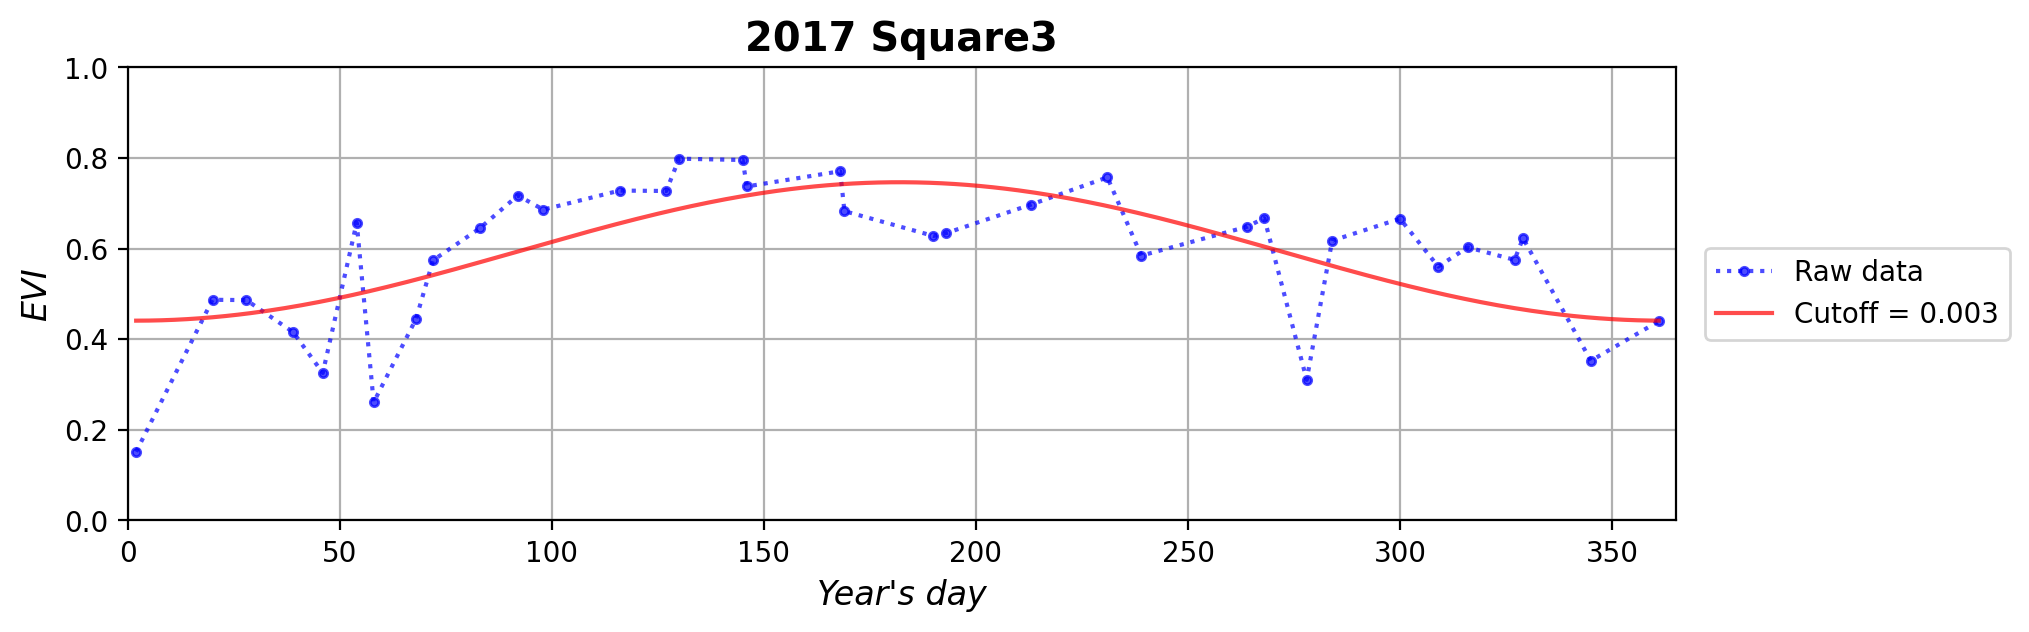

In [22]:
for n in range (len(names)):
    fourierFreqSmoothing(sevNewData[n], 0.003, names[n])

#### 2. Spectral representation

In [23]:
def spectralPlot(modisData, title):
    eviRft = np.fft.rfft(modisData[5])
    
    rank = np.arange(0, len(eviRft), 1)
    
    eviReal = [a.real for a in eviRft]
    eviImag = [b.imag for b in eviRft]
    
    # For highest values
    print("For harmonics of rank 21 to {}:\n\n\
    EVI (real):       mean={}, std={}\n\
    EVI (imaginary):  mean={}, std={}".format(len(eviRft), round(np.mean(eviReal[21::]), 4), round(np.std(eviReal[21::]), 4),
                                                          round(np.mean(eviImag[21::]), 4), round(np.std(eviImag[21::]), 4)))
    
    zeros = np.zeros(len(eviRft))
    
    fig = plt.figure(figsize=(12,3), dpi=200)
    
    plt.title(title, size='x-large', weight='bold')
    plt.plot(rank, eviReal, 'bo', markersize=3, label='Real')
    plt.plot(rank, eviImag, 'ro', markersize=3, label='Imaginary')
    for i in range (21):
        if (eviReal[i] > eviImag[i]) and (eviImag[i] >= 0):
            if eviReal[i] > 20:
                plt.text(i, 21, int(round(eviReal[i])), color='b', horizontalalignment='center')
            else:
                plt.text(i, eviReal[i]+1, int(round(eviReal[i])), color='b', horizontalalignment='center')
            plt.text(i, -2.5, int(round(eviImag[i])), color='r', horizontalalignment='center')
        elif (eviReal[i] > eviImag[i]) and (eviReal[i] <= 0):
            plt.text(i, 1, int(round(eviReal[i])), color='b', horizontalalignment='center')
            if eviImag[i] < -20:
                plt.text(i, -22.5, int(round(eviImag[i])), color='r', horizontalalignment='center')
            else:
                plt.text(i, eviImag[i]-2.5, int(round(eviImag[i])), color='r', horizontalalignment='center')
        elif (eviReal[i] < eviImag[i]) and (eviReal[i] >= 0):
            plt.text(i, -2.5, int(round(eviReal[i])), color='b', horizontalalignment='center')
            if eviImag[i] > 20:
                plt.text(i, 21, int(round(eviImag[i])), color='r', horizontalalignment='center')
            else:
                plt.text(i, eviImag[i]+1, int(round(eviImag[i])), color='r', horizontalalignment='center')
        elif (eviReal[i] < eviImag[i]) and (eviImag[i] <= 0):
            if eviReal[i] < -20:
                plt.text(i, -22.5, int(round(eviReal[i])), color='b', horizontalalignment='center')
            else:
                plt.text(i, eviReal[i]-2.5, int(round(eviReal[i])), color='b', horizontalalignment='center')
            plt.text(i, 1, int(round(eviImag[i])), color='r', horizontalalignment='center')
        elif (eviReal[i] > 0) and (eviImag[i] < 0):
            if eviReal[i] > 20:
                plt.text(i, 21, int(round(eviReal[i])), color='b', horizontalalignment='center')
            else:
                plt.text(i, eviReal[i]+1, int(round(eviReal[i])), color='b', horizontalalignment='center')
            if eviImag[i] < -20:
                plt.text(i, -22.5, int(round(eviImag[i])), color='r', horizontalalignment='center')
            else:
                plt.text(i, eviImag[i]-2.5, int(round(eviImag[i])), color='r', horizontalalignment='center')
        elif (eviReal[i] < 0) and (eviImag[i] > 0):
            if eviReal[i] < -20:
                plt.text(i, -22.5, int(round(eviReal[i])), color='b', horizontalalignment='center')
            else:
                plt.text(i, eviReal[i]-2.5, int(round(eviReal[i])), color='b', horizontalalignment='center')
            if eviImag[i] > 20:
                plt.text(i, 21, int(round(eviImag[i])), color='r', horizontalalignment='center')
            else:
                plt.text(i, eviImag[i]+1, int(round(eviImag[i])), color='r', horizontalalignment='center')
    
    plt.vlines(rank, zeros, eviReal, 'b')
    plt.vlines(rank, zeros, eviImag, 'r')
    plt.ylabel('Amplitude', size='large', style='italic')
    plt.ylim(-20, 20)
    plt.xlabel('Harmonic', size='large', style='italic')
    plt.xlim(-0.5,20.5)
    plt.legend(loc='center left', bbox_to_anchor=(1.01,0.5))
    
    axes = plt.gca()
    
    axes.set_xticks(np.arange(0, 21, 2), minor=False)
    axes.xaxis.set_ticks(range(0, 21, 1), minor=True)
    axes.xaxis.set_tick_params(length=4, which='minor')
    axes.xaxis.grid(True, which='both')
    
    axes.set_yticks([0], minor=True)
    axes.yaxis.set_tick_params(length=4, which='minor')
    axes.yaxis.set_ticklabels(['0'], minor=True)
    axes.set_yticks([-20, -15, -10, -5, 5, 10, 15, 20], minor=False)
    axes.yaxis.set_ticks([-20, -15, -10, -5, 5, 10, 15, 20], minor=False)
    axes.yaxis.grid(True, which='minor')
    
    fig.subplots_adjust(right=0.77)
    
    plt.show()

For harmonics of rank 21 to 181:

    EVI (real):       mean=0.0006, std=0.2064
    EVI (imaginary):  mean=-0.033, std=0.2362


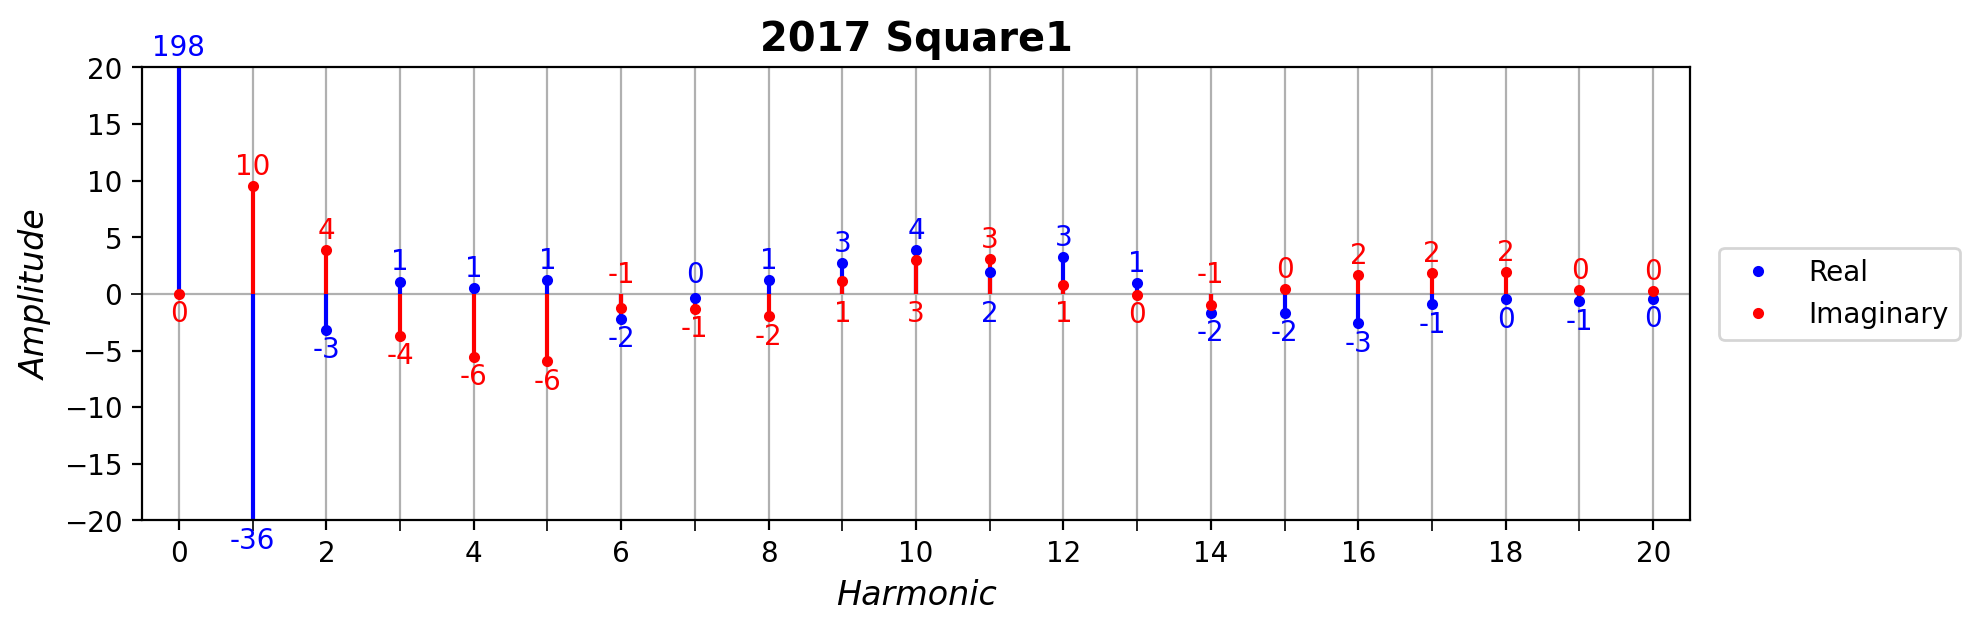




For harmonics of rank 21 to 178:

    EVI (real):       mean=0.0593, std=0.2144
    EVI (imaginary):  mean=-0.0259, std=0.1932


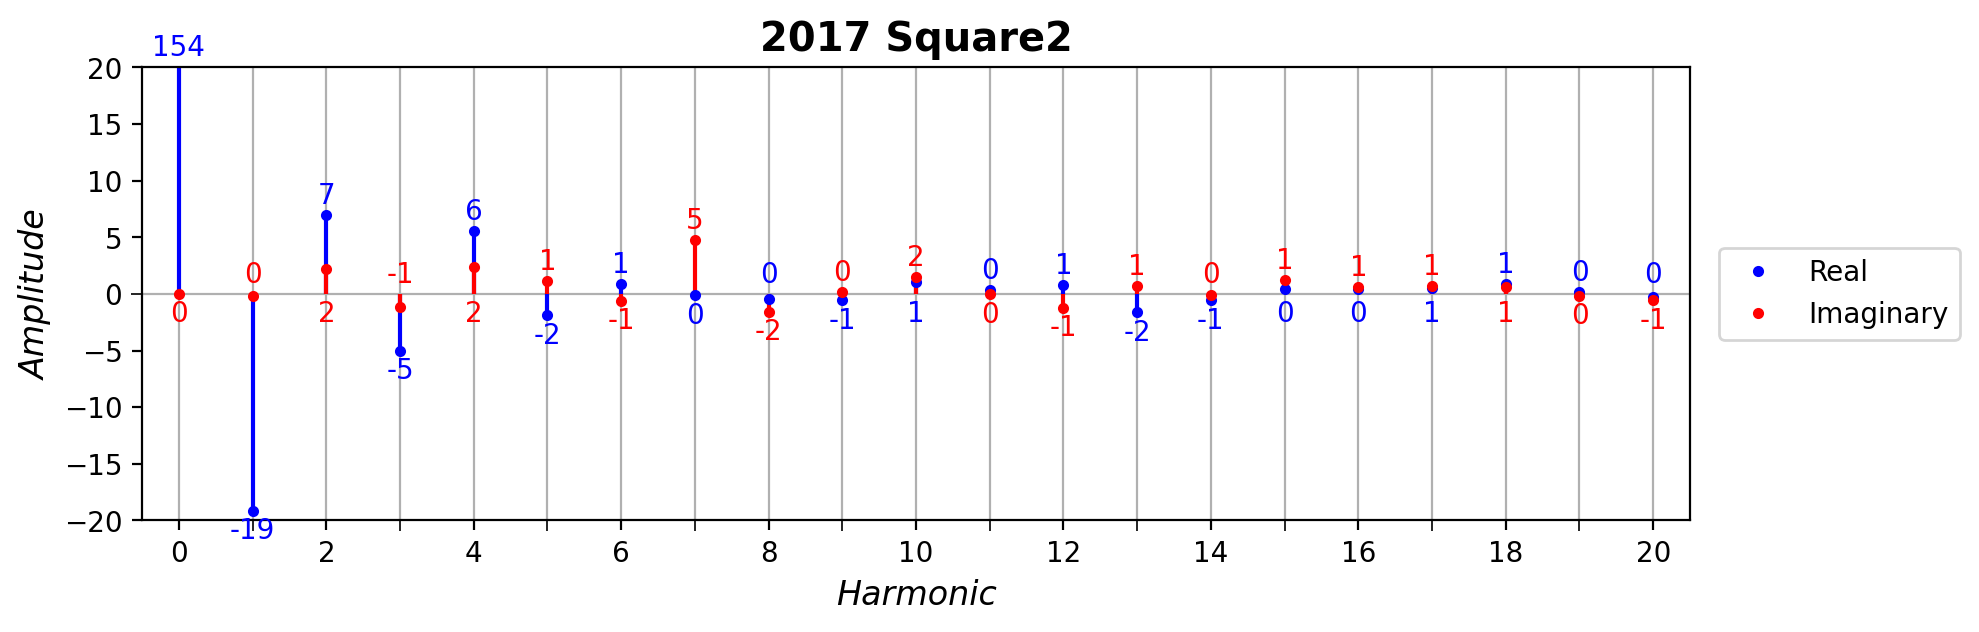




For harmonics of rank 21 to 181:

    EVI (real):       mean=-0.1572, std=0.3153
    EVI (imaginary):  mean=0.1599, std=0.364


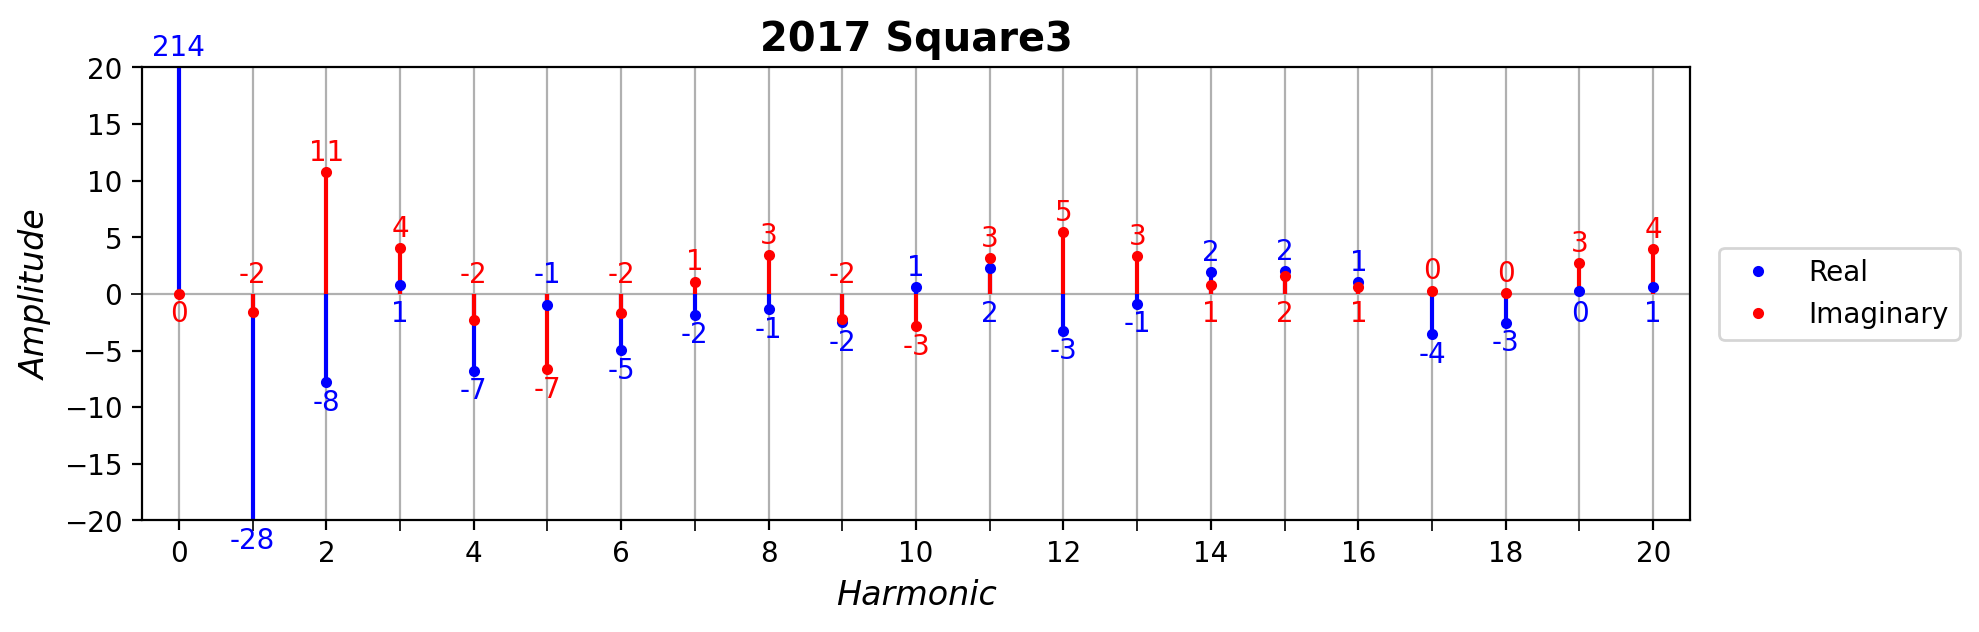

In [24]:
for n in range (len(names)):
    spectralPlot(sevNewData[n], names[n])
    
    if n < len(names) - 1:
        print ('\n\n')

#### 3. Low pass filter with number of harmonics to keep

In [25]:
def fourierHarmoSmoothing(modisData, numberHarmo, title):
    eviRft = np.fft.rfft(modisData[5])
    
    # Set the higher order terms to 0 to smooth
    eviRft[numberHarmo+1::] = 0
    
    eviFourier = np.fft.irfft(eviRft, n=len(modisData[4]))

    graphics([modisData[1], modisData[4]      ],
             [modisData[2], eviFourier],
             ['b:o'       , 'r'               ],
             ['Raw data'  , 'w/ {} harmonic(s)'.format(numberHarmo)  ],
             title)

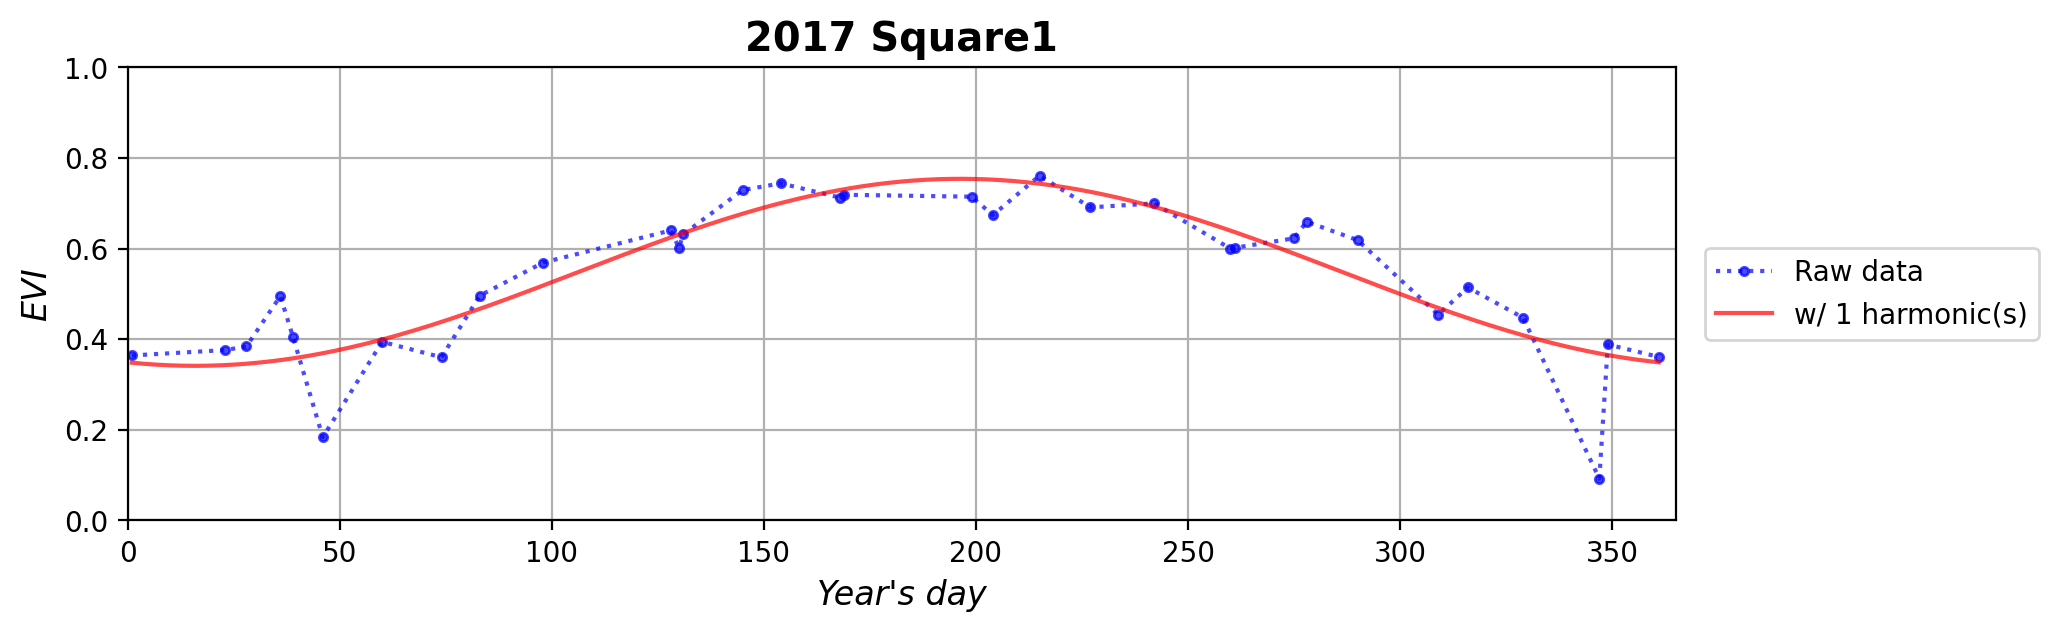

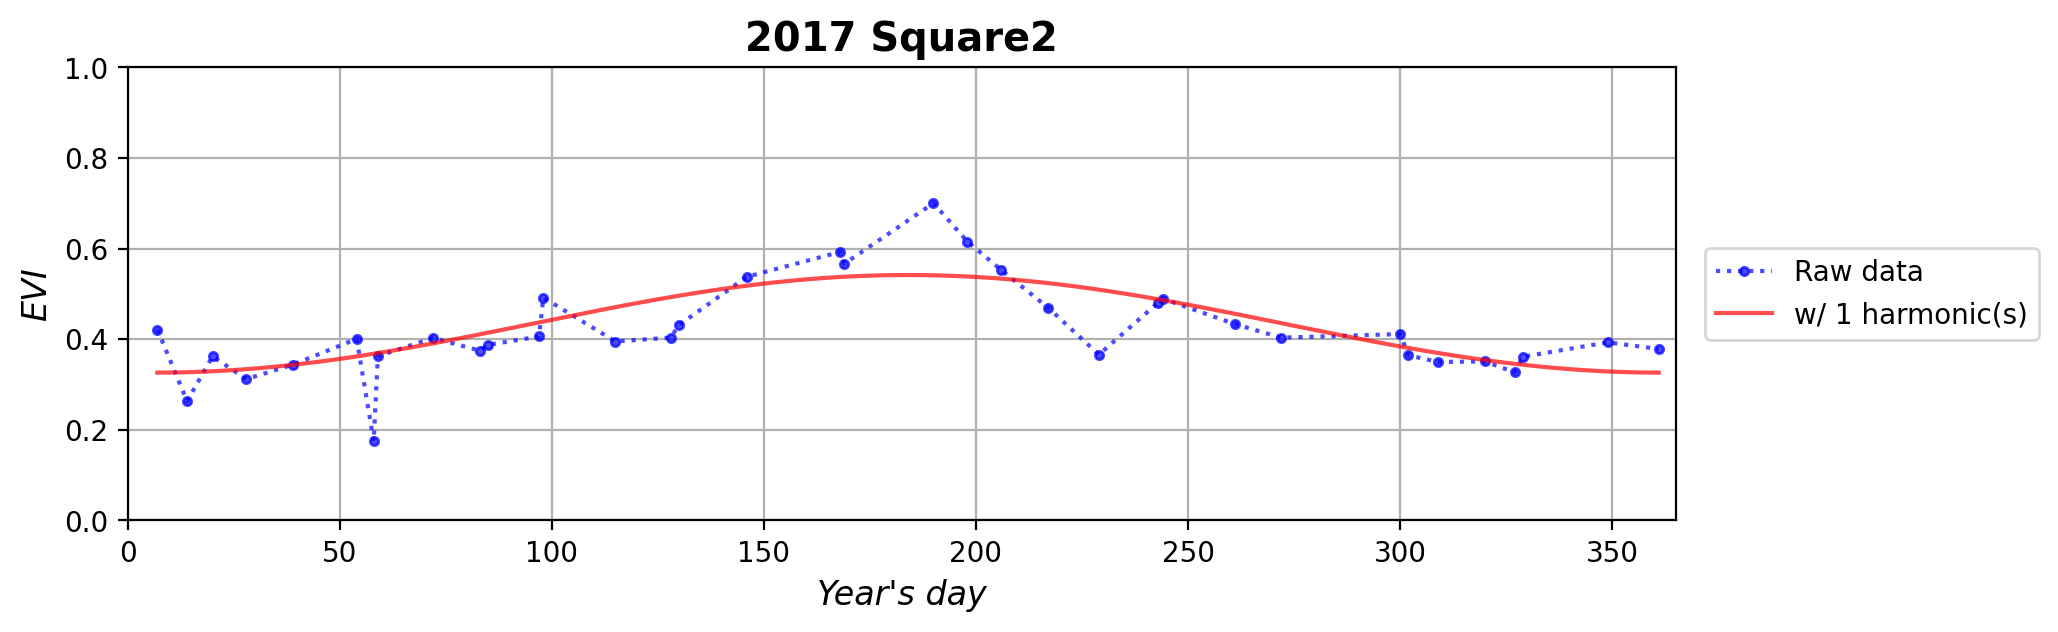

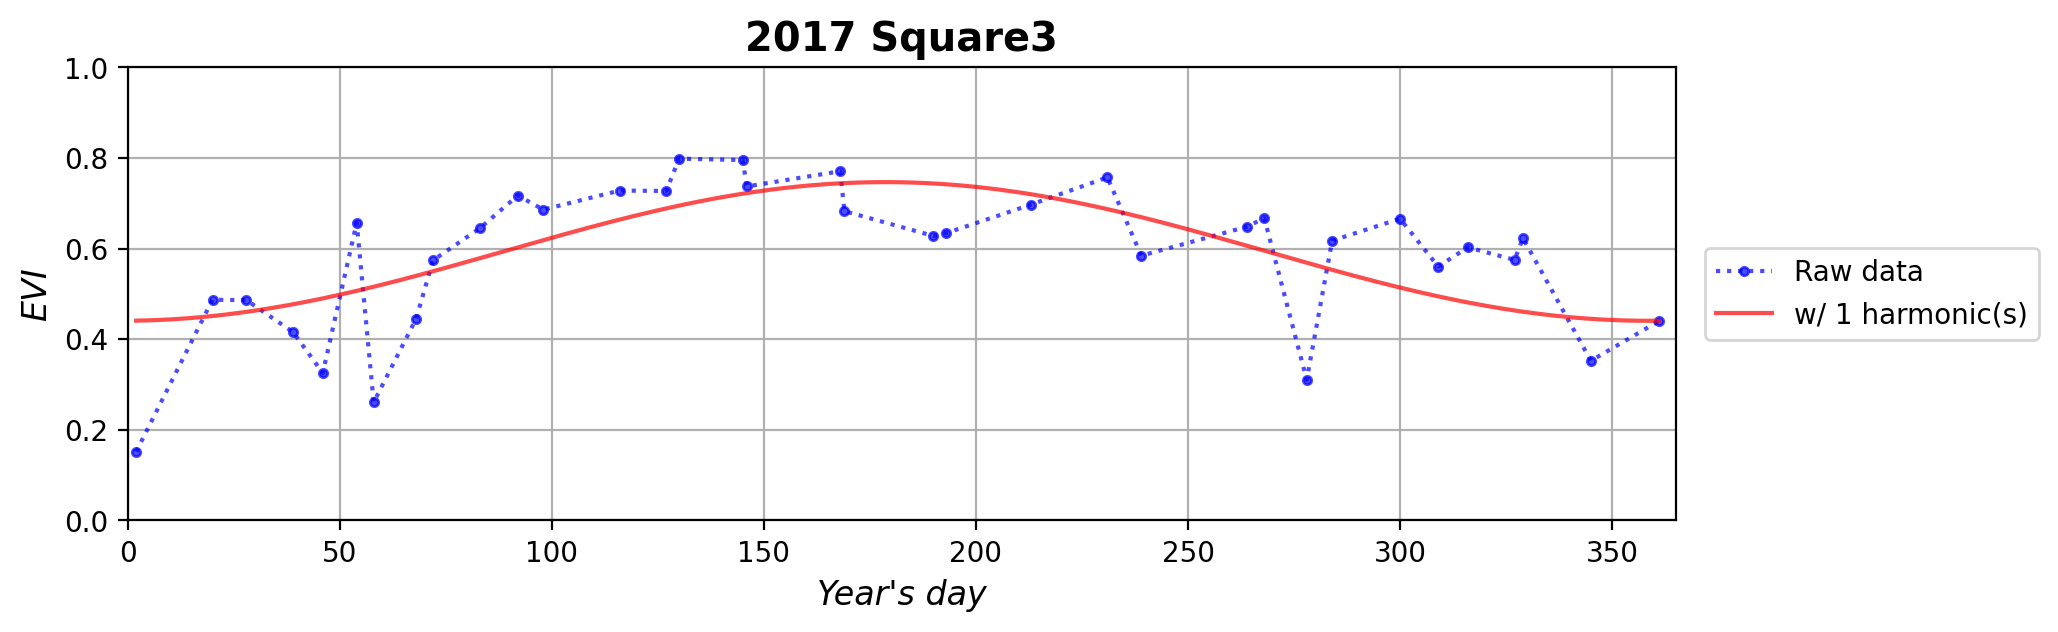

In [26]:
for n in range (len(names)):
    fourierHarmoSmoothing(sevNewData[n], 1, names[n])